# Community Model
We want to combine all 7 bacterial species into one big community model, where bacteria exchange metabolites. This is important to analyse how they interact which each other reagrding e.g. cross-feeding

# Imports and Load Individual Models

In [1]:
# basic
import pandas as pd
import numpy as np
import os
import re

#
from functions import *

# cobra & micom
from cobra.io import read_sbml_model, write_sbml_model
from cobra.flux_analysis import flux_variability_analysis, pfba
from cobra.medium import minimal_medium
from cobra.exceptions import Infeasible, OptimizationError
from cobra import Reaction
from micom import Community
from micom.problems import cooperative_tradeoff
from micom.workflows import tradeoff
# plot
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, LogNorm
import seaborn as sns
import matplotlib.colors as mcolors
from sqlalchemy.sql.coercions import expect
from upsetplot import UpSet, from_indicators
# from pyvis.network import Network
# Clustering
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [2]:
# Ändert das Anzeigeformat der Gleitkommazahlen
pd.options.display.float_format = '{:.5f}'.format

In [3]:
# Load SBML Models
models_path = "../Models/10_duplicate_removal/"
models = {}
for model_name in (f for f in os.listdir(models_path) if f.endswith(".xml")):
    model = read_sbml_model(f"{models_path}/{model_name}")
    model.solver = "cplex"
    name = str(model_name[:3])
    models[name] = model

models = {key: models[key] for key in sorted(models.keys())}  # sorts the dictionary alphabetically
AA1, AA2, AA3, AA4, AA5, AA6, AA7 = [models[f"AA{i}"] for i in range(1, 8)]

In [3]:
# Load SBML Models
models_path = "../Models/12_gap_filled/"
models_filled = {}
for model_name in (f for f in os.listdir(models_path) if f.endswith(".xml")):
    model = read_sbml_model(f"{models_path}/{model_name}")
    model.solver = "cplex"
    name = str(model_name[:3]+"f")
    models_filled[name] = model

models_filled = {key: models_filled[key] for key in sorted(models_filled.keys())}  # sorts the dictionary alphabetically
AA1f, AA2f, AA3f, AA4f, AA5f, AA6f, AA7f = [models_filled[f"AA{i}f"] for i in range(1, 8)]

Restricted license - for non-production use only - expires 2026-11-23


In [99]:
# Load well established models for compariso
ecoli = read_sbml_model("../Models/iML1515.xml")
ecoli.solver = "cplex"
pseudo = read_sbml_model("../Models/iJN1463.xml")
pseudo.solver = "cplex"

In [121]:
get_basic_amounts(models)

AA1 has 2276 reactions and 1514 metabolites
AA2 has 2699 reactions and 1796 metabolites
AA3 has 2247 reactions and 1503 metabolites
AA4 has 2815 reactions and 1763 metabolites
AA5 has 2150 reactions and 1448 metabolites
AA6 has 2602 reactions and 1691 metabolites
AA7 has 2534 reactions and 1658 metabolites


In [122]:
get_basic_amounts(models_filled)

AA1 has 2276 reactions and 1514 metabolites
AA2 has 2699 reactions and 1796 metabolites
AA3 has 2247 reactions and 1503 metabolites
AA4 has 2815 reactions and 1763 metabolites
AA5 has 2150 reactions and 1448 metabolites
AA6 has 2602 reactions and 1691 metabolites
AA7 has 2534 reactions and 1658 metabolites


In [8]:
set([rxn.id for rxn in AA5f.reactions]) - set([rxn.id for rxn in AA5.reactions])
# make sure that reactions were added to the gap filled model but no artefacts remain (like sink reactions from testing gap filling)

{'ACGS', 'G1PACT', 'PGAMT'}

In [9]:
len(syncom_filled.reactions)

17709

In [10]:
len(syncom_filled.metabolites)

11899

# Functions

In [5]:
def check_early_biomass_component(model, medium_dict, check_rxn_id):
    rxn_id = "objective_check"
    sad_mets = []

    check_mets = model.reactions.get_by_id(check_rxn_id).metabolites
    #check_mets = model.reactions.check_rxn_id.metabolites
    for met, flux in check_mets.items():
        if flux < 0: # only look at mets that are consumed
            #print(met)
            stoich = {met: flux}

            if rxn_id in model.reactions: # biomass test reaction is updated
                rxn = model.reactions.get_by_id(rxn_id)
                rxn.subtract_metabolites(rxn.metabolites)
                rxn.add_metabolites(stoich)
            else: # first time reaction is created
                new_rxn = Reaction(id=rxn_id, name="objective reaction", lower_bound=0, upper_bound=1000)
                new_rxn.add_metabolites(stoich)
                model.add_reactions([new_rxn])

            model.objective = rxn_id

            with model:
                change_medium(model, medium_dict)
                try:
                    pfba_flux = pfba(model)
                    if pfba_flux[rxn_id] == 0:
                        sad_mets.append(met.id)
                except Infeasible:
                    print("Cannot get result because pfba is infeasible")

    if rxn_id in model.reactions:
        rxn = model.reactions.get_by_id(rxn_id)
        model.remove_reactions([rxn])

    print(sad_mets)

# Create Community Model
we want to combine our 7 models into one; they'll share one compartment where they can exchange metabolites.

In [20]:
for model in models.values():
    model.reactions.ATPM.lower_bound = 1
    model.reactions.ATPM.upper_bound = 1

## MICOM

with A7; if you run everything without changes we'll get infeasible flux solution; only if I change all lower bounds of all EXchange reactions to -1000 then we get a feasible solution (MICOM changed the lower bounds for all EX reactions that go from a bacterium into the medium to -100)

in comparison i tried the whole community model creation without AA7 and there it works directly without changing anything

In [6]:
taxonomy = pd.read_csv("../Datasets/community_model.csv", sep=";")
taxonomy

,id,genus,species,reactions,metabolites,file,abundance
0,AA1,Stenotrophomonas,Stenotrophomonas maltophilia,2261,1513,/home/lisa/Dokumente/Programmierung/Models/10_...,16
1,AA2,Brucella,Brucella pituitosa,2669,1789,/home/lisa/Dokumente/Programmierung/Models/10_...,5
2,AA3,Curtobacterium,Curtobacterium pusillum,2223,1501,/home/lisa/Dokumente/Programmierung/Models/10_...,8
3,AA4,Enterobacter,Enterobacter ludwigii,2795,1758,/home/lisa/Dokumente/Programmierung/Models/10_...,65
4,AA5,Chryseobacterium,Chryseobacterium indologenes,2107,1446,/home/lisa/Dokumente/Programmierung/Models/10_...,1
5,AA6,Herbaspirillum,Herbaspirillum robiniae,2578,1685,/home/lisa/Dokumente/Programmierung/Models/10_...,2
6,AA7,Pseudomonas,Pseudomonas putida,2522,1655,/home/lisa/Dokumente/Programmierung/Models/10_...,3


I talked with Nadine in my meeting on the 06 June and we decided that at the beginning we're not going to use abundances

In [7]:
# without abundance
syncom = Community(taxonomy.iloc[:, :-1], name="synthetic seven member bacterial community", id="C7", solver="cplex")

# change lower bound of Exchange reactions (EX between bacteria and medium)
for rxn in syncom.reactions.query("^EX_"):
    rxn.lower_bound = -1000

Output()

### Community with gap filled models

In [6]:
taxonomy_gap_filled = pd.read_csv("../Datasets/community_model_gap_filled.csv", sep=";")
syncom_filled = Community(taxonomy_gap_filled.iloc[:, :-1], name="synthetic seven member bacterial community", id="C7", solver="cplex")

Output()

In [7]:
 e# change lower bound of Exchange reactions (EX between bacteria and medium)
for rxn in syncom_filled.reactions.query("^EX_"):
    rxn.lower_bound = -1000

## Evaluate Syncom

In [21]:
syncom_EX = syncom.reactions.query("^EX_")
print(f"My syncom has in total {len(syncom_EX)} EX reactions.")

My syncom has in total 2571 EX reactions.


In [ ]:
total_EX = 0
for model in models.values():
    EX = [rxn.id for rxn in model.reactions if rxn.id.startswith("EX_")]
    total_EX += len(EX)
    print(f"Model {model.id} has {len(EX)} EX reactions.")
print(f"That means there are in total {total_EX} EX reactions in my 7 models.")

syncom_nonM_EX = [rxn for rxn in syncom.reactions.query("^EX_") if not rxn.id.endswith("m")]
print(f"There are {len(syncom_nonM_EX)} EX reactions from my models into shared medium in the syncom.")

In [ ]:
all_EX = set()
for model in models.values():
    EX = [rxn.id for rxn in model.reactions if rxn.id.startswith("EX_")]
    all_EX.update(EX)
print(f"There are {len(all_EX)} unique EX reactions in my 7 models.", )

EX_syncom_m = [rxn for rxn in syncom.reactions.query("^EX_") if rxn.id.endswith("m")]
print(f"There are {len(EX_syncom_m)} EX reactions from/into _m in my syncom.", )

In [ ]:
trimmed_all_EX = {s[:-2] for s in all_EX}  # assuming all_EX is a set of strings
trimmed_EX_syncom_m = {rxn.id[:-2] for rxn in EX_syncom_m}  # handle Reaction objects

diff = trimmed_all_EX - trimmed_EX_syncom_m
diff

In [ ]:
diff = trimmed_EX_syncom_m - trimmed_all_EX
diff

In [ ]:
syncom.reactions.query("EX_acon_C")

In [ ]:
for rxn in syncom.reactions.query("^EX_"):
    print(rxn.id[len(rxn.id)-3:], rxn.lower_bound)

### Micom Test Data

In [ ]:
from micom.data import test_taxonomy

taxonomy_test = test_taxonomy()
taxonomy_test

In [ ]:
from micom import Community

com = Community(taxonomy_test)

In [ ]:
from micom.data import test_db
from micom.data import test_data

data = test_data()
data

In [ ]:
taxonomy = pd.read_csv("../Datasets/community_model_build.csv", sep=";")

In [ ]:
from micom.workflows import build
manifest = build(taxonomy=taxonomy, out_folder="../", cutoff=0.0001, threads=2, model_db=None, solver="cplex")

In [ ]:
mre_jin = pd.read_csv("../Datasets/Medium/medium_ARE_Jin.csv", sep=";")

In [ ]:
medium_mre_m9 = pd.concat([m9, mre_jin], ignore_index=True)

In [ ]:
from micom.workflows import grow
res = grow(manifest, model_folder="../", medium=medium_mre_m9, tradeoff=0.5, threads=2)

In [ ]:
print(com.objective.expression)
com.optimize()

In [ ]:
sol = com.cooperative_tradeoff(fraction=1.0)
sol

In [ ]:
com

## PyCoMo
wir bleiben bei MICOM, da das mehr etabliert ist

In [ ]:
from pathlib import Path
import sys
import cobra
import os

In [ ]:
path_root = "/home/lisa/miniconda3/envs/MA/lib/python3.10/site-packages/pycomo-0.2.8.dist-info"
sys.path.append(path_root)
import pycomo
pycomo.configure_logger(level="INFO")

In [ ]:
test_model_dir = "../Models/10_duplicate_removal"
# needed to change solver to cplex
named_models = pycomo.load_named_models_from_dir(test_model_dir)

In [ ]:
for model in named_models.values():
    print(model.objective)

In [ ]:
single_org_models = []
for name, model in named_models.items():
    print(name)
    single_org_model = pycomo.SingleOrganismModel(model, name)
    single_org_models.append(single_org_model)

In [ ]:
community_name = "lisas_endless_pain"
com_model_obj = pycomo.CommunityModel(single_org_models, community_name)

In [ ]:
com_model_obj.model

In [ ]:
# at the moment there is a fixed grwoth but with variable abundance
com_model_obj.summary()

In [ ]:
# we can change the simulation that we have set abundance and variable grwoth (like it should be)
com_model_obj.convert_to_fixed_abundance()
abundance_dict = com_model_obj.generate_equal_abundance_dict()
com_model_obj.apply_fixed_abundance(abundance_dict)
com_model_obj.summary()

# Medium

In [7]:
def change_medium_bounds(medium_df, carbon_bound, non_carbon_bound=1000):
    if not isinstance(medium_df, pd.DataFrame):
        return "please df :c"

    medium_df = medium_df.copy()

    medium_df["bound"] = np.where(
    medium_df["reaction"].isin(m9_rxn),
        non_carbon_bound,   # value if reaction is in m9_rxn
        carbon_bound)       # value if not

    return medium_df

## M9

In [6]:
m9 = pd.read_csv("../Datasets/Medium/medium_M9.csv", sep=";")

In [7]:
m9_rxn = list(m9["reaction"])

## Maize Root Exudate

In [90]:
# based on https://pmc.ncbi.nlm.nih.gov/articles/PMC5726377/pdf/EJSS-68-806.pdf
mre_naveed = pd.read_csv("../Datasets/Medium/medium_MRE_Naveed.csv", sep=";")

In [91]:
mre_krumbach = pd.read_csv("../Datasets/Medium/medium_MRE_Krumbach.csv", sep=";")
# this is the more core medium

In [ ]:
# this is the very extensive list of metabolites from LC-MS aka table s1
og_medium = pd.read_csv("../krumbach_og_medium.csv", sep=";", header=None)
print(len(set(og_medium[0])))
set(og_medium[0])

In [87]:
mre_jin = pd.read_csv("../Datasets/Medium/medium_MRE_Jin.csv", sep=";")

## Combined MARE & M9 with bounds

In [8]:
medium_combined_naveed = pd.read_csv("../Datasets/Medium/medium_combined_Naveed_M9.csv", sep=";", quotechar='"')
medium_combined_krumbach= pd.read_csv("../Datasets/Medium/medium_combined_Krumbach_M9.csv", sep=";", quotechar='"')

## Ashley Beck

In [11]:
medium_beck = pd.read_csv("../Datasets/Medium/medium_Beck.csv", sep=";")

## Ecoplate

In [9]:
ecoplate = pd.read_csv("../Datasets/Medium/medium_ecoplate_carbon.csv", sep=";", quotechar='"')
ecoplate_rxns = [safe_parse(x) for x in ecoplate["reaction"]]

# Medium comparison

In [92]:
set_jin = set(mre_jin["reaction"])
set_naveed = set(mre_naveed["reaction"])
set_krumbach = set(mre_krumbach["reaction"])

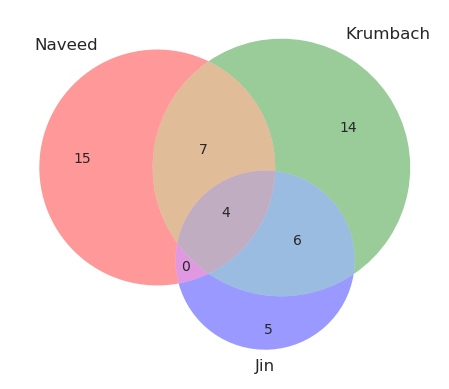

In [93]:
from matplotlib_venn import venn3
venn3((set_naveed, set_krumbach, set_jin), set_labels=('Naveed', 'Krumbach', 'Jin'))
plt.show()

In [20]:
# Create a union of all reactions
all_reactions = set_naveed | set_krumbach | set_jin

# Build a DataFrame showing presence (1) or absence (0) in each set
venn_df = pd.DataFrame({
    'reaction': list(all_reactions),
    'in_naveed': [1 if rxn in set_naveed else 0 for rxn in all_reactions],
    'in_krumbach': [1 if rxn in set_krumbach else 0 for rxn in all_reactions],
    'in_jin': [1 if rxn in set_jin else 0 for rxn in all_reactions]
})

In [116]:
naveed_cat = pd.read_csv("../Datasets/Naveed_medium_categories.csv", sep=";", quotechar='"')
krumbach_cat = pd.read_csv("../Datasets/Krumbach_medium_categories.csv", sep=";", quotechar='"')

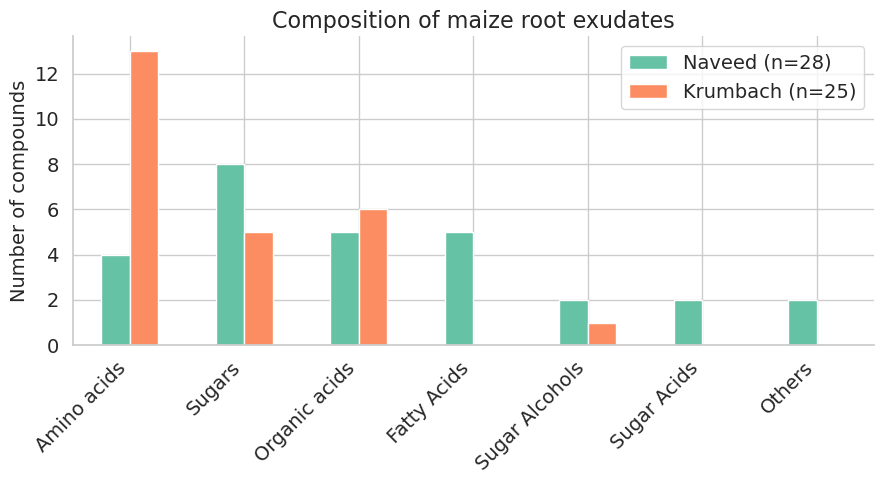

In [119]:
cat_counts1 = naveed_cat["Category"].value_counts()
cat_counts2 = krumbach_cat["Category"].value_counts()

df_compare = pd.DataFrame({
    f"Naveed (n={len(naveed_cat)})": cat_counts1,
    f"Krumbach (n={len(krumbach_cat)})": cat_counts2
}).fillna(0)

# Sort by total
df_compare["total"] = df_compare.sum(axis=1)
df_compare = df_compare.sort_values("total", ascending=False)

# Move "others" to the end if it exists
if "Others" in df_compare.index:
    df_compare = pd.concat([
        df_compare.drop("Others"),
        df_compare.loc[["Others"]]
    ])

# Drop helper column
df_compare = df_compare.drop(columns="total")

# Style
sns.set_theme(style="whitegrid")  # white background + light gray grid

# Pick a nice muted color palette
colors = sns.color_palette("Set2", n_colors=df_compare.shape[1])

# Plot
ax = df_compare.plot(
    kind="bar",
    figsize=(9, 5),       # adjust for print size
    color=colors
)

plt.ylabel("Number of compounds", fontsize=14)
plt.xlabel("")
plt.title("Composition of maize root exudates", fontsize=16)
plt.xticks(rotation=45, ha="right", fontsize=14)
plt.yticks(fontsize=14)

# Legend
plt.legend(fontsize=14)

# Remove top and right spines for cleaner look
sns.despine()
plt.tight_layout()
plt.savefig("../Figures/medium_comparison_barplot.pdf", format="pdf", dpi=300)  # high-quality PDF
plt.show()

In [102]:
len(krumbach_cat)

25

# Simulations I - Growth & Niches

In [22]:
all_models = {**models, 'Community': syncom}

In [10]:
all_models_filled = {**models_filled, 'Community': syncom_filled}

The limited version is when all the bacteria in the community actually share one medium, so they would only have 1/7 of the og medium.

## Growth on Maize ARE & M9

When comparing the Naveed and krumbach medium, there are especially differences in the community. Because with krumbach we see growth for AA1 which isn't the case for naveed. AA3 doesnt show growth at the moment in the individual models because of the low bounds for the carbon soirces in the medium.

In [ ]:
# there is definitely a difference between pfba and the cooperative tradeoff function from MICOM
# with pfba i dont have growth for aa1 and aa5 in the community, that is why when i first used the krumbach medium
# i kinda dismissed it because there wasnt really a change in comparison to naveed
# but now with the micom function there actually is
with syncom:
    chill_medium = change_medium_bounds(medium_combined_krumbach, 1000)
    change_medium(syncom, chill_medium)
    com_fluxes = pfba(syncom_filled).fluxes # funnily i get NO error with the syncom that is not filled but maybe that was luck

# gets you an error because of pFBA

In [26]:
for model in all_models_filled.values():
    growth_val = test_medium(model, medium_beck)
    print(model.id, ": ", growth_val)

AA1 :  4.357781605893641
AA2 :  14.158444923248128
AA3 :  1.6721018815020645
AA4 :  10.925028570494632
AA5 :  10.859117739184253
AA6 :  10.975139202528348
AA7 :  14.03441775282472
C7 :  model
AA1   14.62651
AA2   17.89780
AA3    3.48710
AA4   15.78198
AA5   20.16625
AA6   13.78563
AA7   14.90130
Name: Growth, dtype: float64


In [25]:
for model in all_models.values():
    chill_medium = change_medium_bounds(medium_beck, 200, non_carbon_bound=1000)
    growth_val = test_medium(model, chill_medium)
    print(model.id, ": ", growth_val)

AA1 :  0.0
AA2 :  23.363103231066148
AA3 :  8.408898203581192
AA4 :  39.94555916162176
AA5 :  0.0
AA6 :  28.51455181697144
AA7 :  27.19425311230267
C7 :  model
AA1   31.29966
AA2   38.39613
AA3   24.99789
AA4   43.23286
AA5    0.04155
AA6   43.14488
AA7   42.81015
Name: Growth, dtype: float64


In [16]:
for model in all_models_filled.values():
    print(test_medium(model, medium_combined_krumbach))

10.684004015899328
0.0
1.9584272055034475
16.735081796546574
12.546695393311563
15.041074253374257
15.5278721107666
model
AA1   17.87199
AA2   18.80990
AA3   14.67610
AA4   14.61263
AA5   15.02492
AA6   14.94007
AA7   15.20783
Name: Growth, dtype: float64


In [16]:
for model in all_models_filled.values():
    growth_val = test_medium(model, medium_combined_naveed)
    print(model.id, ": ", growth_val)

AA1 :  12.627834449630024
AA2 :  0.0
AA3 :  1.187837109963803
AA4 :  16.838073691204862
AA5 :  13.221138314579772
AA6 :  14.004710482938082
AA7 :  15.730749675525526
C7 :  model
AA1   12.59747
AA2   14.59677
AA3    0.00011
AA4   33.14038
AA5   19.32665
AA6   17.46808
AA7   21.45642
Name: Growth, dtype: float64


In [12]:
growth_ind_krumbach = []
growth_ind_naveed = []
growth_com_krumbach = []
growth_com_naveed = []
for model in all_models_filled.values():
    ### Krumbach
    growth_val = test_medium(model, medium_combined_krumbach, frac=1)
    if model.id == "C7":
        growth_com_krumbach = growth_val
    else:
        growth_ind_krumbach.append(growth_val)
    print(model.id, ": ", growth_val, "K")

    ### Naveed
    growth_val = test_medium(model, medium_combined_naveed, frac=1)
    if model.id == "C7":
        growth_com_naveed = growth_val
    else:
        growth_ind_naveed.append(growth_val)
    print(model.id, ": ", growth_val, "N")

AA1 :  10.684004015899331 K
AA1 :  12.667948515873357 N
AA2 :  0.0 K
AA2 :  0.0 N
AA3 :  1.9584272055034488 K
AA3 :  1.1878371099638008 N
AA4 :  16.735081796546574 K
AA4 :  16.838286242180303 N
AA5 :  12.546695393311563 K
AA5 :  13.221138314579646 N
AA6 :  15.04107425337435 K
AA6 :  14.004710482938158 N
AA7 :  15.5278721107666 K
AA7 :  15.84179026147043 N
C7 :  model
AA1   17.87257
AA2   18.78915
AA3   14.67616
AA4   14.65126
AA5   15.02212
AA6   14.94332
AA7   15.18875
Name: Growth, dtype: float64 K
C7 :  model
AA1   12.78252
AA2   14.59689
AA3    0.00017
AA4   33.07732
AA5   19.56314
AA6   17.98236
AA7   21.34633
Name: Growth, dtype: float64 N


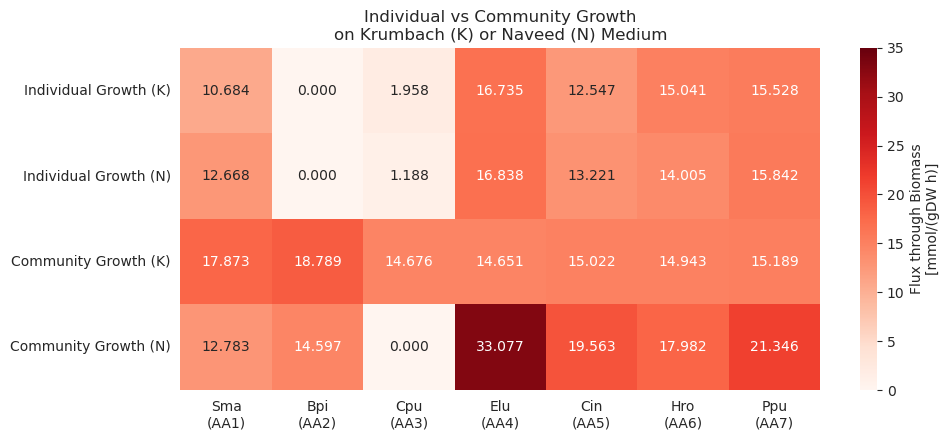

In [16]:
data = np.array([growth_ind_krumbach, growth_ind_naveed, list(growth_com_krumbach), list(growth_com_naveed)])
bac_names = ["Sma\n(AA1)", "Bpi\n(AA2)", "Cpu\n(AA3)", "Elu\n(AA4)", "Cin\n(AA5)", "Hro\n(AA6)", "Ppu\n(AA7)"]

df = pd.DataFrame(data,
                  index=["Individual Growth (K)", "Individual Growth (N)", "Community Growth (K)", "Community Growth (N)"],
                  columns=bac_names)

plt.figure(figsize=(10, 4.5))
sns.heatmap(df, annot=True, fmt=".3f", cmap="Reds", cbar_kws={'label': 'Flux through Biomass\n[mmol/(gDW h)]'},
            vmax=35)
plt.title("Individual vs Community Growth\non Krumbach (K) or Naveed (N) Medium")
plt.tight_layout()

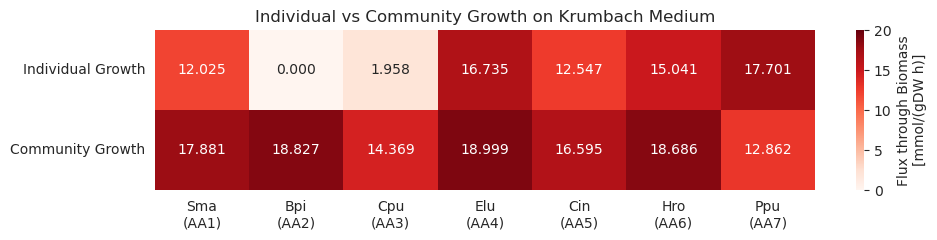

In [61]:
# Combine into 2D array for heatmap
growth_ind = [0 if x is None else x for x in growth_ind_krumbach]
data = np.array([growth_ind, list(growth_com_krumbach)])

#bac_names = ["AA1", "AA2", "AA3", "AA4", "AA5", "AA6", "AA7"]
#bac_names = ["Sma", "Bpi", "Cpu", "Elu", "Cin", "Hro", "Ppu"]
bac_names = ["Sma\n(AA1)", "Bpi\n(AA2)", "Cpu\n(AA3)", "Elu\n(AA4)", "Cin\n(AA5)", "Hro\n(AA6)", "Ppu\n(AA7)"]

# Create a DataFrame for better labeling
df = pd.DataFrame(data,
                  index=["Individual Growth", "Community Growth"],
                  columns=bac_names)

#tree_order = ["Cin", "Ppu", "Sma", "Elu", "Bpi", "Hro", "Cpu"]
#df = df[tree_order]  # Reorder columns

# Plot
plt.figure(figsize=(10, 2.5))
sns.heatmap(df, annot=True, fmt=".3f", cmap="Reds", cbar_kws={'label': 'Flux through Biomass\n[mmol/(gDW h)]'},
            vmax=20)
plt.title("Individual vs Community Growth on Krumbach Medium")
plt.tight_layout()
#plt.show()
#plt.savefig("../Figures/Biomass_Ind_Com_KrumbachMed.svg")

it is also important to note that for the community I really should use the cooperative tradeoff function from MICOM; normal pfba() gets me infeasible solution quite often

AA2 is able to grow within the community model although it was previously not able to grow on its own (nice!) AA2 needed thiamine to grow.

lets check AA2 within the community

In [20]:
fluxies = get_pfba_fluxes(syncom_filled, medium_combined_krumbach)

In [21]:
# AA7 secretes thm into medium
fluxies[(fluxies.index.str.contains('thm_e')) &
    (fluxies > 0)]

reaction_id
EX_thm_e__AA3   0.00001
EX_thm_e__AA4   0.00001
EX_thm_e__AA5   0.00001
EX_thm_e__AA7   0.00388
Name: flux, dtype: float64

In [23]:
with AA7f:
    change_medium(AA7f, medium_combined_krumbach)
    aa7 = pfba(AA7f).fluxes

In [24]:
aa7[(aa7.index.str.contains('thm_e'))]
# AA7 only secretes thm in the community, on its own, it doesnt do that

EX_thm_e   0.00000
Name: fluxes, dtype: float64

In [27]:
aa2_min = minimal_medium(AA2f, minimize_components=True)

In [28]:
aa2_min # cobra function packt auch thm ins minimal medium rein

EX_2pglyc_e       0.09640
EX_ca2_e          0.00052
EX_cl_e           0.00052
EX_cobalt2_e      0.00001
EX_cu2_e          0.00007
EX_fe3dhbzs_e   275.85959
EX_k_e            0.01952
EX_mg2_e          0.00087
EX_mn2_e          0.00007
EX_o2_e         363.92622
EX_thm_e          0.00002
EX_tsul_e         0.01252
EX_zn2_e          0.00003
dtype: float64

why does AA3 has such a small (biological feasible lol) growth rate in comparison to the others?

In [33]:
aa3_min = minimal_medium(AA3f, 20, minimize_components=5) # force high growth

In [34]:
aa3_min

,0,1,2,3
EX_ca2_e,0.10410,0.10410,0.10659,0.10544
EX_cgly_e,0.00000,0.00000,80.29043,109.76683
EX_cl_e,0.10410,0.10410,0.10659,0.10544
EX_cobalt2_e,0.00200,0.00200,0.00205,0.00203
EX_cu2_e,0.01418,0.01418,0.01452,0.01436
EX_fe3dcit_e,111.36323,116.85146,126.67191,127.82857
EX_gam6p_e,1000.00000,0.00000,857.56747,0.00000
EX_gly_cys_e,103.61257,0.00000,0.00000,0.00000
EX_gthrd_e,0.00000,1000.00000,0.00000,0.00000
EX_h2o2_e,0.00000,0.00000,0.00000,157.42295


different C sources in a high quantity are needed. growth rates with my maize medium are biological feasible so maybe AA3 is the only model that actually works lol

In [35]:
syncom_min = minimal_medium(syncom_filled, 1.5, minimize_components=5)

Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.
The MIP version of minimal media is extremely slow for models that large :(
Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.


## Ecoplate Substrate Utilisation

In [23]:
metab_axis = ["Phenylethylamine", "Putrescine", "Glycyl-glutamic acid", "L-arginine", "Asparagine", "Phenylalanine", "Serine", "Threonine", "Glycerol-phosphate", "Cellobiose", "Mannitol", "Xylose", "Glucose-1-phosphate", "Acetyl-glucosamine", "4-Hydroxy benzoic acid", "Galacturonic acid", "Malic acid", "2-Hydroxy-benzoic acid", "Lactose", "Butyric acid", "Water (Control)"]

[08/18/25 13:30:32] WARNING  There does not seem to be any carbon source in your medium. Please    ]8;id=26732;file:///home/lisa/miniconda3/envs/MA/lib/python3.10/site-packages/micom/community.py\community.py]8;;\:]8;id=71266;file:///home/lisa/miniconda3/envs/MA/lib/python3.10/site-packages/micom/community.py#667\667]8;;\
                             double-check your medium IDs.                                                         

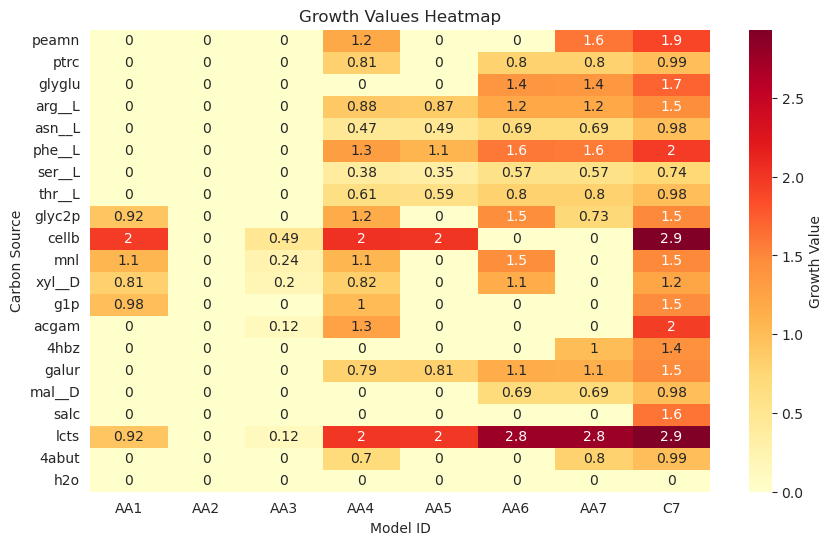

In [24]:
ecoplate_df = create_medium(ecoplate_rxns, m9_rxn, all_models_filled, 10, carbon_only=True)
# in comparison to some older versions of the plot, this may look different becaus enow i use the carbon_only = True option, so we still have bounds = 1000 for all the M9 metabolites (and therefore get higher groeth values especially in C7)

In [25]:
# for nicer visualisation: better labels
ecoplate_df.index = metab_axis
ecoplate_df.columns = ["Sma", "Bpi", "Cpu", "Elu", "Cin", "Hro", "Ppu", "Community"]
ecoplate_df = ecoplate_df.fillna(0)

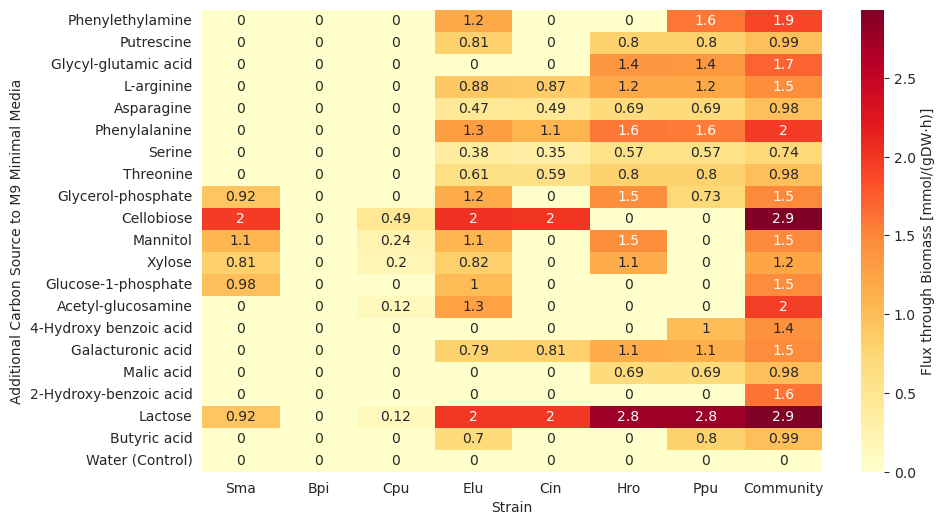

In [26]:
# Create a heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(ecoplate_df, annot=True, cmap="YlOrRd", cbar_kws={'label': 'Flux through Biomass [mmol/(gDW·h)]'})
# plt.title("")
plt.xlabel("Strain")
#plt.yticks(ticks=np.arange(len(metab_axis)), labels=metab_axis)
plt.ylabel("Additional Carbon Source to M9 Minimal Media")
#plt.savefig("../Figures/ecoplate.svg", format="svg", bbox_inches="tight")
plt.show()


In [ ]:
# all reactions in the M9 have a bound of 1000, only bounds of carbon reactions are modified
# AA7 can grow with carbon sources <500, i.e. especially O2 is limiting (i saw that in other simulations, that o2 ans fructose were the ones with highest flux values)
create_medium(ecoplate_rxns, m9_rxn, all_models, 45, carbon_only=True)

## Growth on Different Carbon Sources

In [14]:
carbon_sources = ["EX_glc__D_e", "EX_sucr_e", "EX_xyl__D_e", ["EX_mal__L_e", "EX_mal__L_e"], "EX_pyr_e", "EX_succ_e", ["EX_ala__L_e", "EX_ala__L_e"], "EX_glu__L_e", "EX_gly_e"]

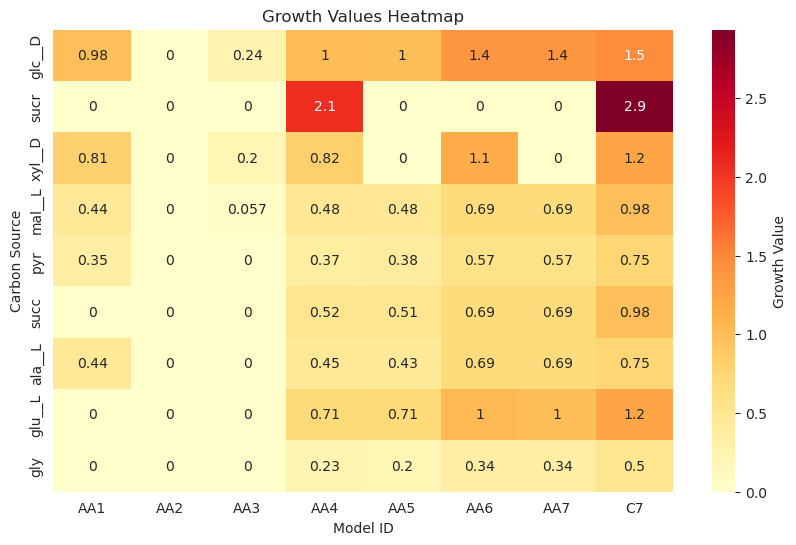

In [15]:
carbon_df = create_medium(carbon_sources, m9_rxn, all_models_filled, 10, carbon_only=True)

In [21]:
# nicer plot with nicer labels
carbon_df.index = ["Glucose", "Sucrose", "Xylose", "Malate", "Pyruvate", "Succinate", "Alanine", "Glutamate", "Glycine"]
carbon_df.columns = ["Sma", "Bpi", "Cpu", "Elu", "Cin", "Hro", "Ppu", "Community"]
carbon_df = carbon_df.fillna(0)

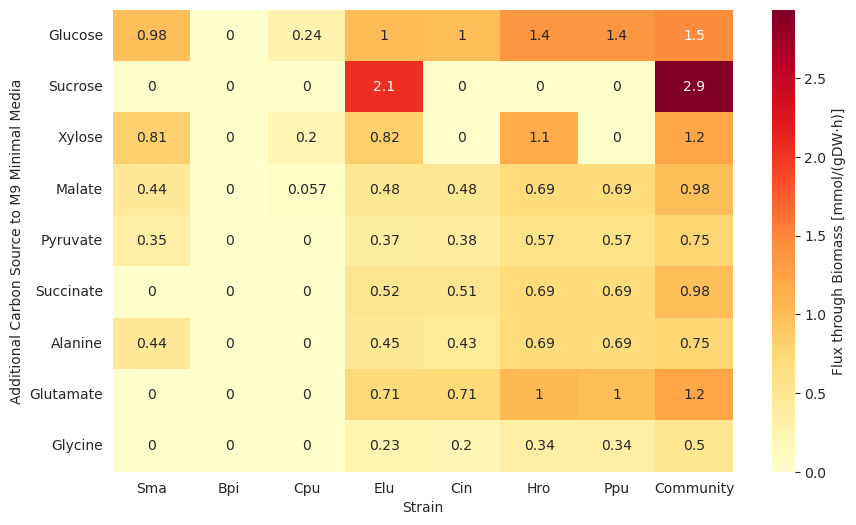

In [22]:
# Create a heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(carbon_df, annot=True, cmap="YlOrRd", cbar_kws={'label': 'Flux through Biomass [mmol/(gDW·h)]'})
# plt.title("")
plt.xlabel("Strain")
plt.ylabel("Additional Carbon Source to M9 Minimal Media")
#plt.savefig("../Figures/growth_diff_carbon_sources.svg", format="svg", bbox_inches="tight")
plt.show()

## Aufnahme und Abgabe

### per individual model

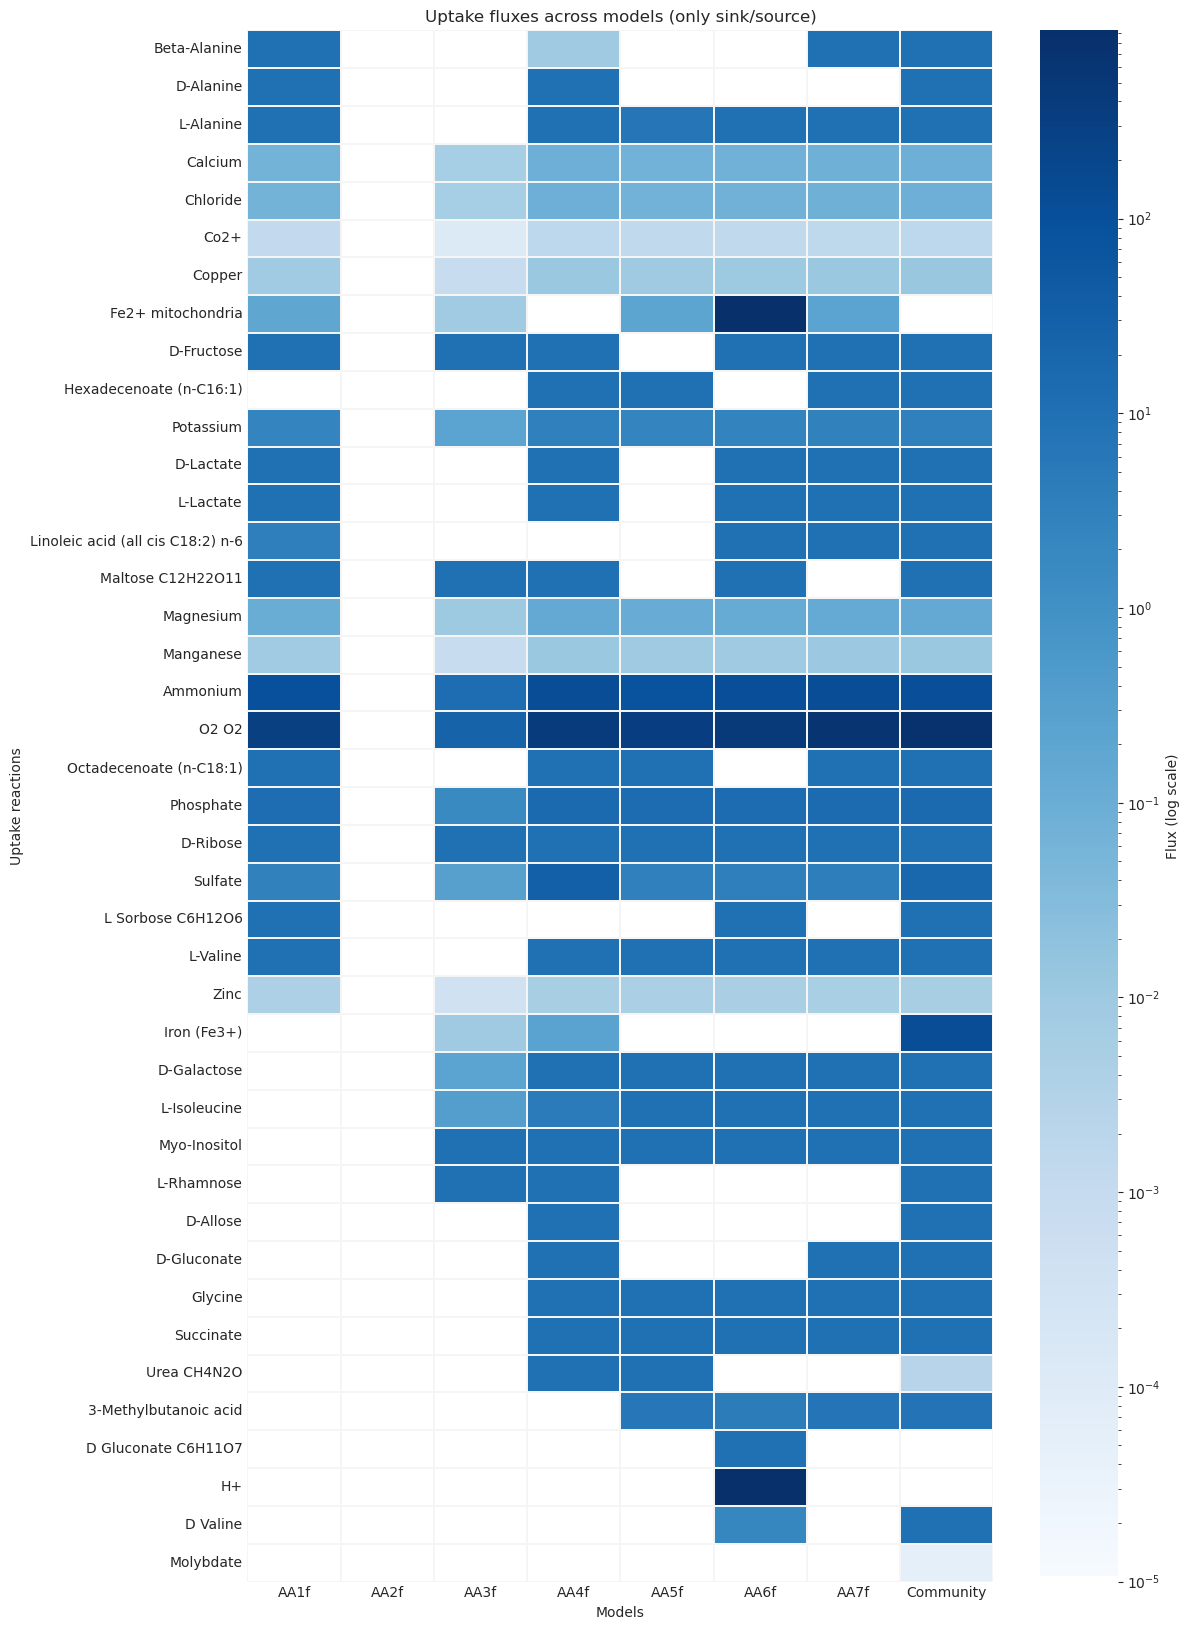

In [36]:
# the code for the community works in a way it only looks at EX reactions into/from the medium and outside and NO EX into/from a model into the medium
uptake_df = uptake_secret_heatmap(all_models_filled, "uptake", medium_combined_naveed, c7_all_ex = "no")

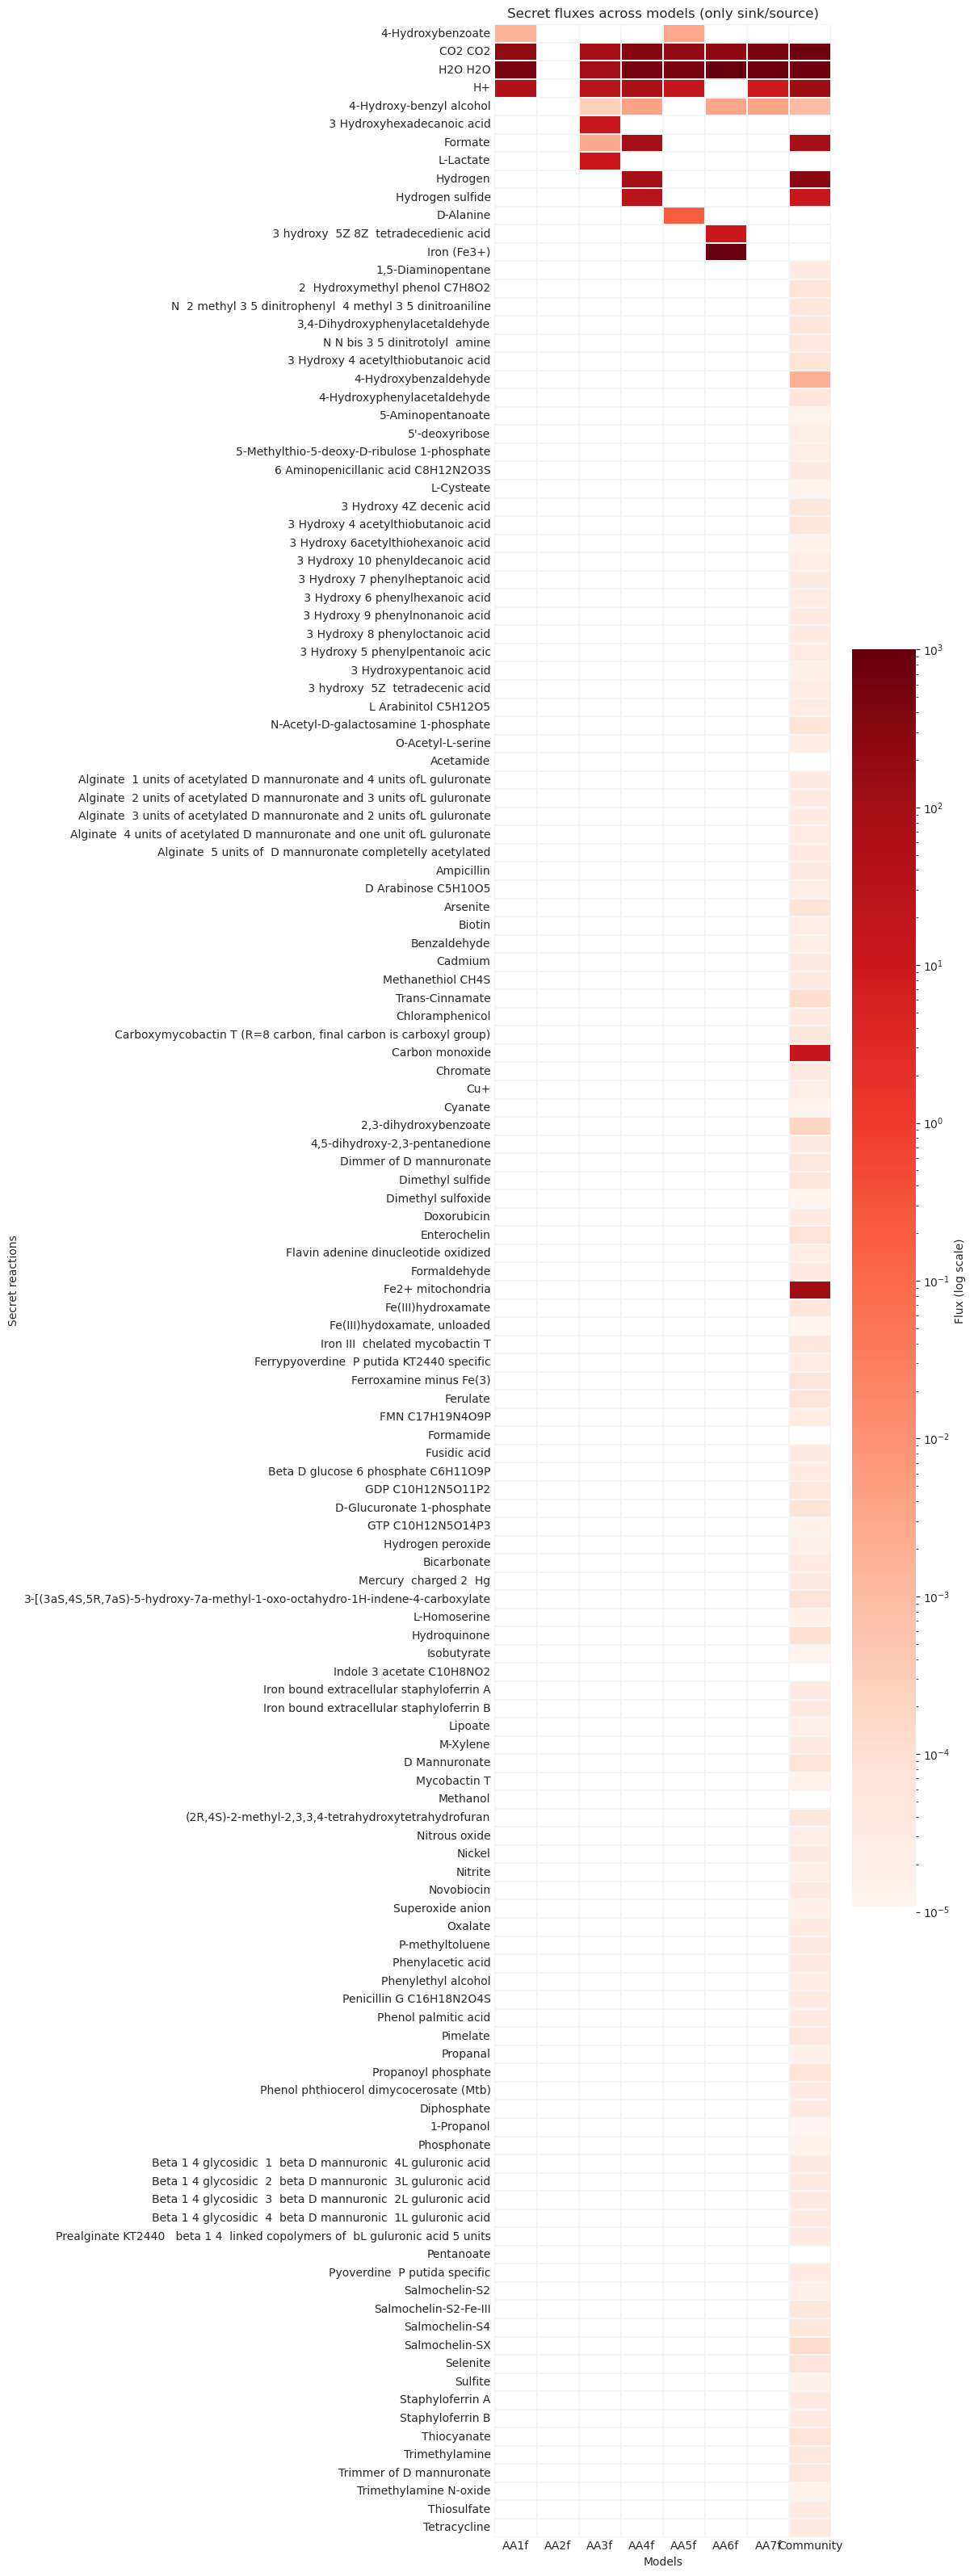

In [72]:
secretion_df = uptake_secret_heatmap(all_models_filled, "secret", medium_combined_naveed, c7_all_ex = "no")

### individuals on personal minimal media

it may be interessting to see the metabolic niches of all my bacteria. but because some of them are not able to grow on their own, i would disregard the medium right now and maybe use the minimal medium for each of the bacteria determined by cobrapy.

Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.
Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.


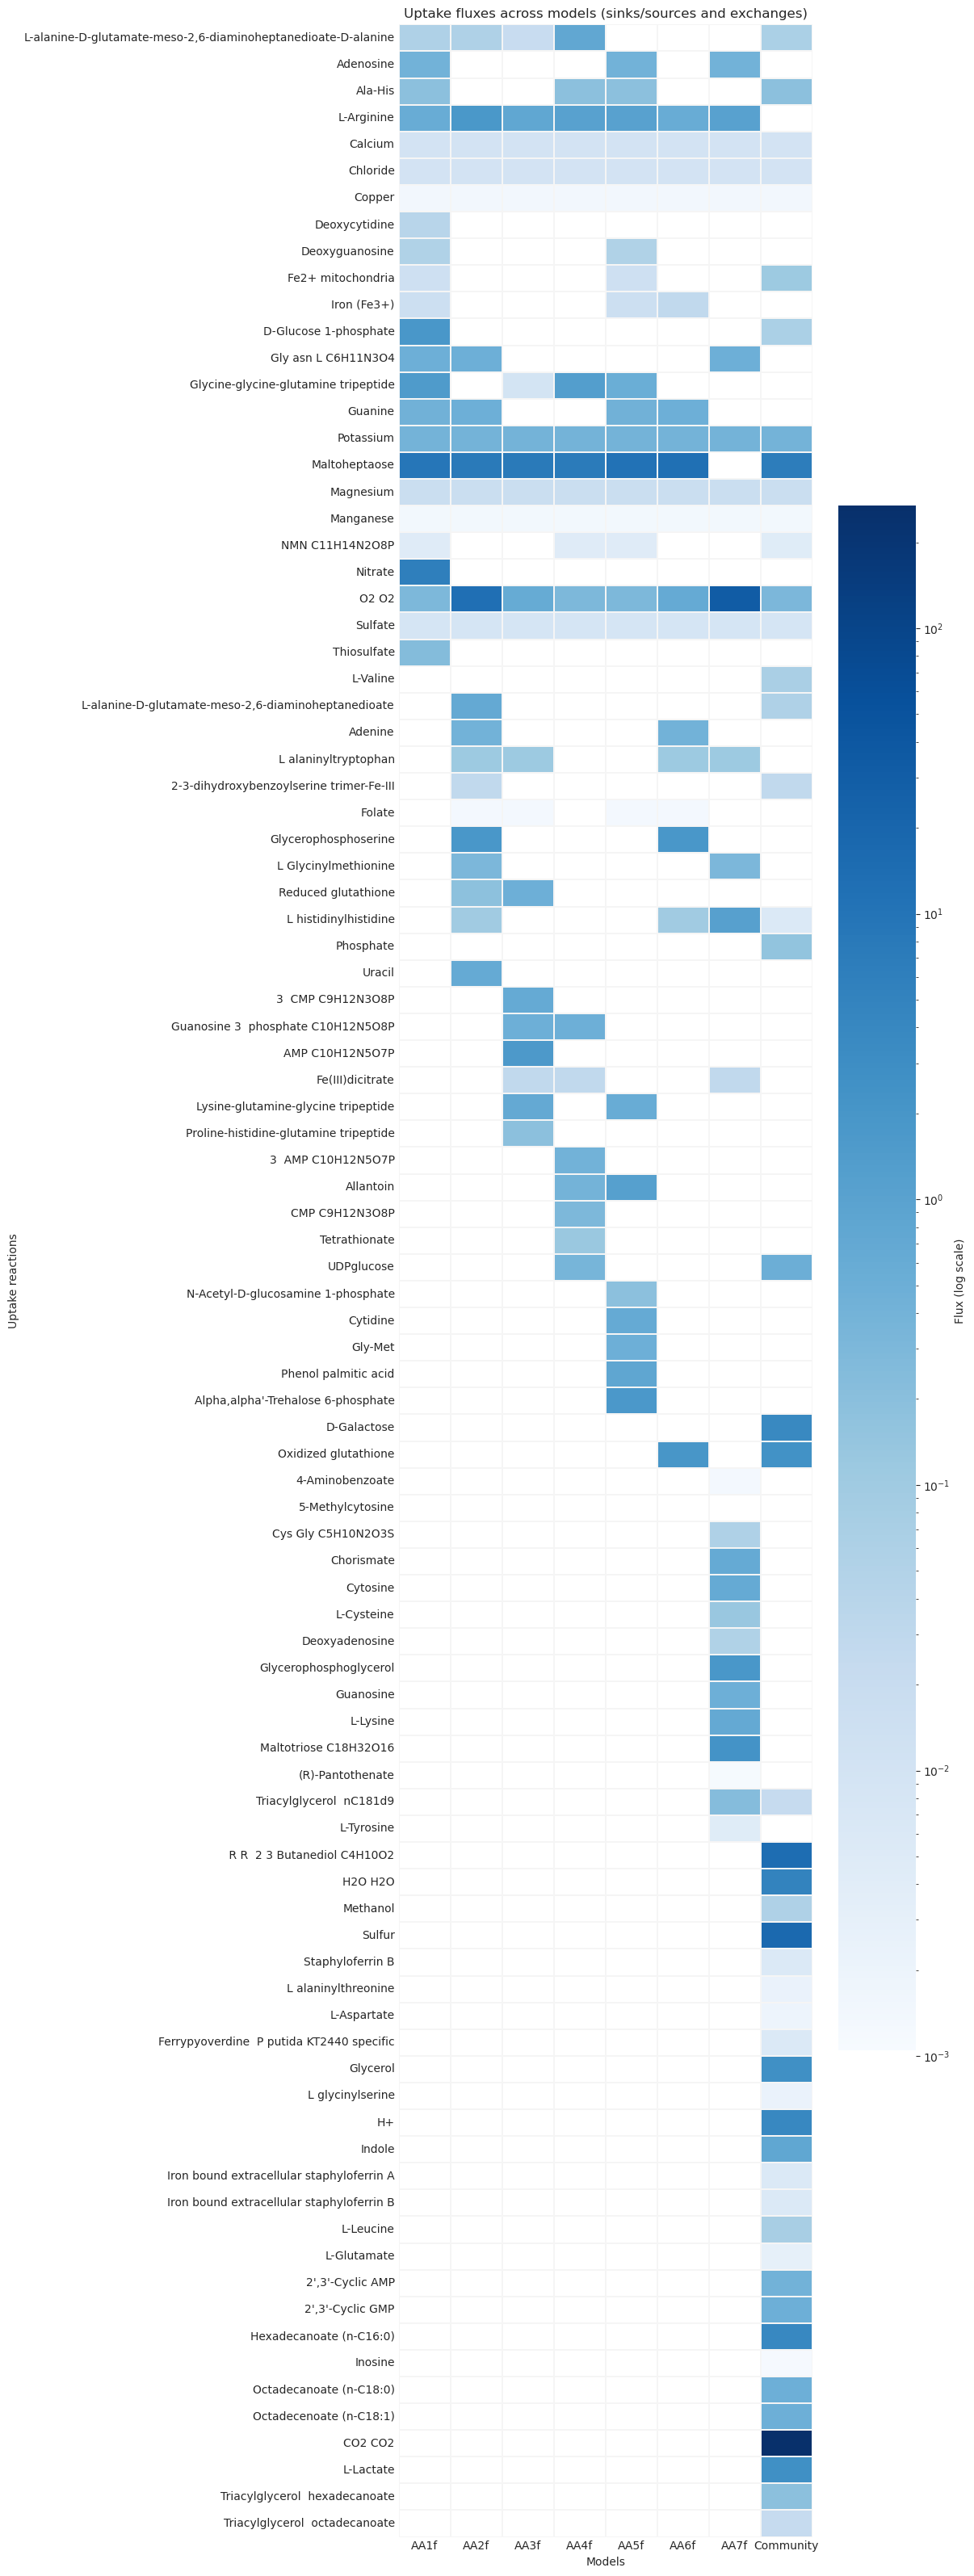

In [39]:
df_uptakes_all = uptake_secret_heatmap(all_models_filled, "uptake", c7_all_ex="yes", vmin=0.001)

Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.
Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.


,AA1f,AA2f,AA3f,AA4f,AA5f,AA6f,AA7f,Community
Acetaldehyde,2.535679e+01,22.506284,77.381573,NaN,19.784134,59.331373,NaN,1.670702e+01
CO2 CO2,1.089688e+02,107.497567,18.757761,6.301791e+01,141.723182,116.547093,3.484621e+01,5.550936e+01
Ethanol,7.398308e+01,74.346693,NaN,1.267875e-12,90.978397,97.859270,1.721290e-12,1.589694e+01
Hydrogen sulfide,5.037082e-13,NaN,NaN,NaN,NaN,3.469201,NaN,2.925778e+00
L-Lactate,8.267760e+00,NaN,NaN,NaN,NaN,3.644755,NaN,2.618631e-06
3 Hydroxyhexadecanoic acid,NaN,NaN,2.208448,NaN,NaN,NaN,NaN,5.962509e-06
Carbon monoxide,NaN,NaN,84.742083,NaN,NaN,49.455865,NaN,4.638387e+01
H2O H2O,NaN,NaN,64.974983,NaN,NaN,NaN,3.755406e+01,8.788384e-05
Succinate,NaN,NaN,0.328896,1.938025e+01,NaN,NaN,NaN,5.666988e+00
R R 2 3 Butanediol C4H10O2,NaN,NaN,NaN,3.660638e+01,NaN,NaN,NaN,2.276665e+01


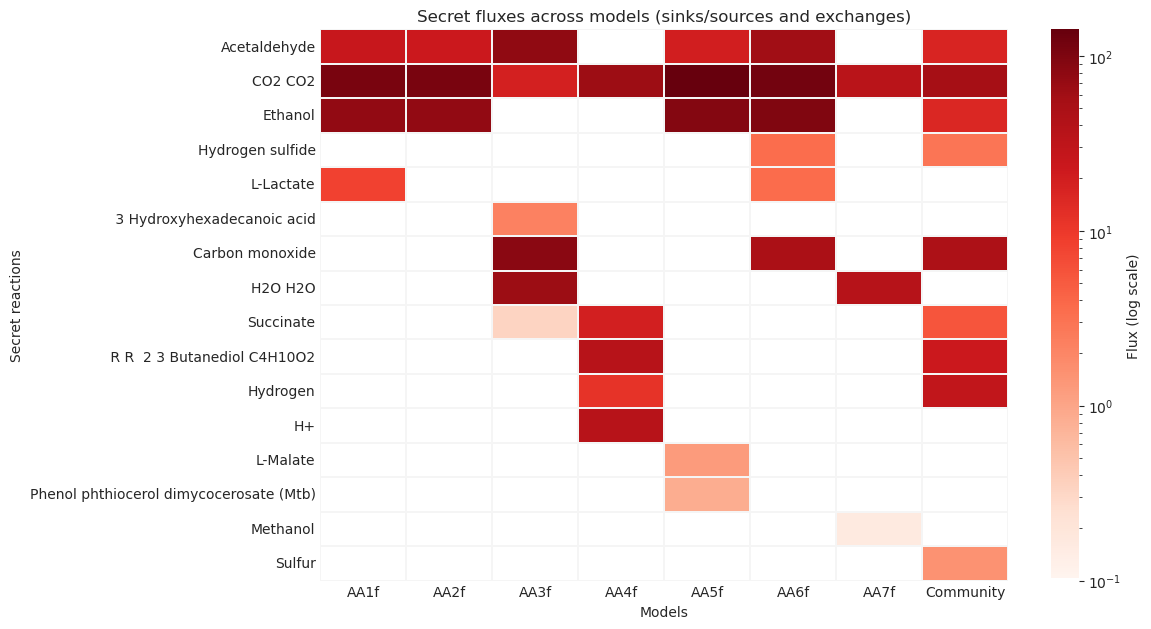

In [77]:
uptake_secret_heatmap(all_models_filled, "secret", c7_all_ex="yes", vmin=0.1)

I think the community lacks a bit of uptake because the above plots only check for uptake/secretion into the medium from the outside. all metabolites that are secreted and uptaken by the members are disregarded. however in the paper it is very likely that the would measure that as well because the medium compartment doesnt exist in RL

Get the Uptakes and Secretion Fluxes more in detail; Comparison between individual model and their behaviour in the community

In [ ]:
def compare_rxn_lists(com_index, single_index, model_id):
    # Convert to sets
    set1 = list(com_index)
    set2 = set(single_index)

    # Cut off the last 5 characters from each ID in list1
    set1 = set([rxn[:-5] for rxn in set1])

    # Reactions in both lists
    shared = set1 & set2  # or set1.intersection(set2)

    # unique reactions
    unique_to_list1 = set1 - set2
    unique_to_list2 = set2 - set1

    return shared, unique_to_list1, unique_to_list2

In [30]:
def get_uptake_secrets(model, medium, type):
    syncom_fluxes = get_pfba_fluxes(syncom, medium)
    single_flux = get_pfba_fluxes(model, medium)

    if type == "uptake":
        com_uptakes = syncom_fluxes[(syncom_fluxes.index.str.startswith('EX_')) &
                            (syncom_fluxes.index.str.endswith(f'_{model.id}')) &
                            (syncom_fluxes < 0)]
        single_uptakes = single_flux[(single_flux.index.str.startswith('EX_')) &
                        (single_flux < 0)]
    elif type == "secret":
        com_uptakes = syncom_fluxes[(syncom_fluxes.index.str.startswith('EX_')) &
                            (syncom_fluxes.index.str.endswith(f'_{model.id}')) &
                            (syncom_fluxes > 0)]
        single_uptakes = single_flux[(single_flux.index.str.startswith('EX_')) &
                        (single_flux > 0)]
    else:
        return "Specify either \"uptake\" or \"secret\" as type"

    shared, unique_to_com, unique_to_single = compare_rxn_lists(com_uptakes.index, single_uptakes.index, model.id)
    return shared, unique_to_com, unique_to_single


In [ ]:
uptake_single, uptake_com, uptake_shared, secret_single, secret_com, secret_shared = [], [], [], [], [], []

for model in models.values():
    up_shared, up_unique_to_com, up_unique_to_single = get_uptake_secrets(model, medium_mre_m9, "uptake")
    uptake_single.append(up_unique_to_single)
    uptake_com.append(up_unique_to_com)
    uptake_shared.append(up_shared)

    sec_shared, sec_unique_to_com, sec_unique_to_single = get_uptake_secrets(model, medium_mre_m9, "secret")
    secret_single.append(sec_unique_to_single)
    secret_com.append(sec_unique_to_com)
    secret_shared.append(sec_shared)

# if Infeasible, change the bounds within the Community to 1000, see MICOM creation

In [ ]:
labels = [f"AA{i}" for i in range(1, 8)]  # ['AA1', 'AA2', ..., 'AA7']
df_uptakes_secrets = pd.DataFrame({
    'model': labels,
    'uptake_single': uptake_single,
    'uptake_com': uptake_com,
    'uptake_shared': uptake_shared,
    'secret_single': secret_single,
    'secret_com': secret_com,
    'secret_shared': secret_shared
})

In [ ]:
df_uptakes_secrets

In [ ]:
from itertools import chain
# Flatten two levels: from list of sets to a single iterable of elements
unique_list = sorted(set(chain.from_iterable(chain.from_iterable([
    uptake_single, uptake_com, uptake_shared, secret_single, secret_com, secret_shared]))))
uptake_mets = sorted(set(chain.from_iterable(chain.from_iterable([
    uptake_single, uptake_com, uptake_shared]))))
secret_mets = sorted(set(chain.from_iterable(chain.from_iterable([
    secret_single, secret_com, secret_shared]))))
unique_mets = sorted(set(chain.from_iterable(chain.from_iterable([
    uptake_single, uptake_com, secret_single, secret_com]))))

### Uptakes within Community

check within community who produces what for whom

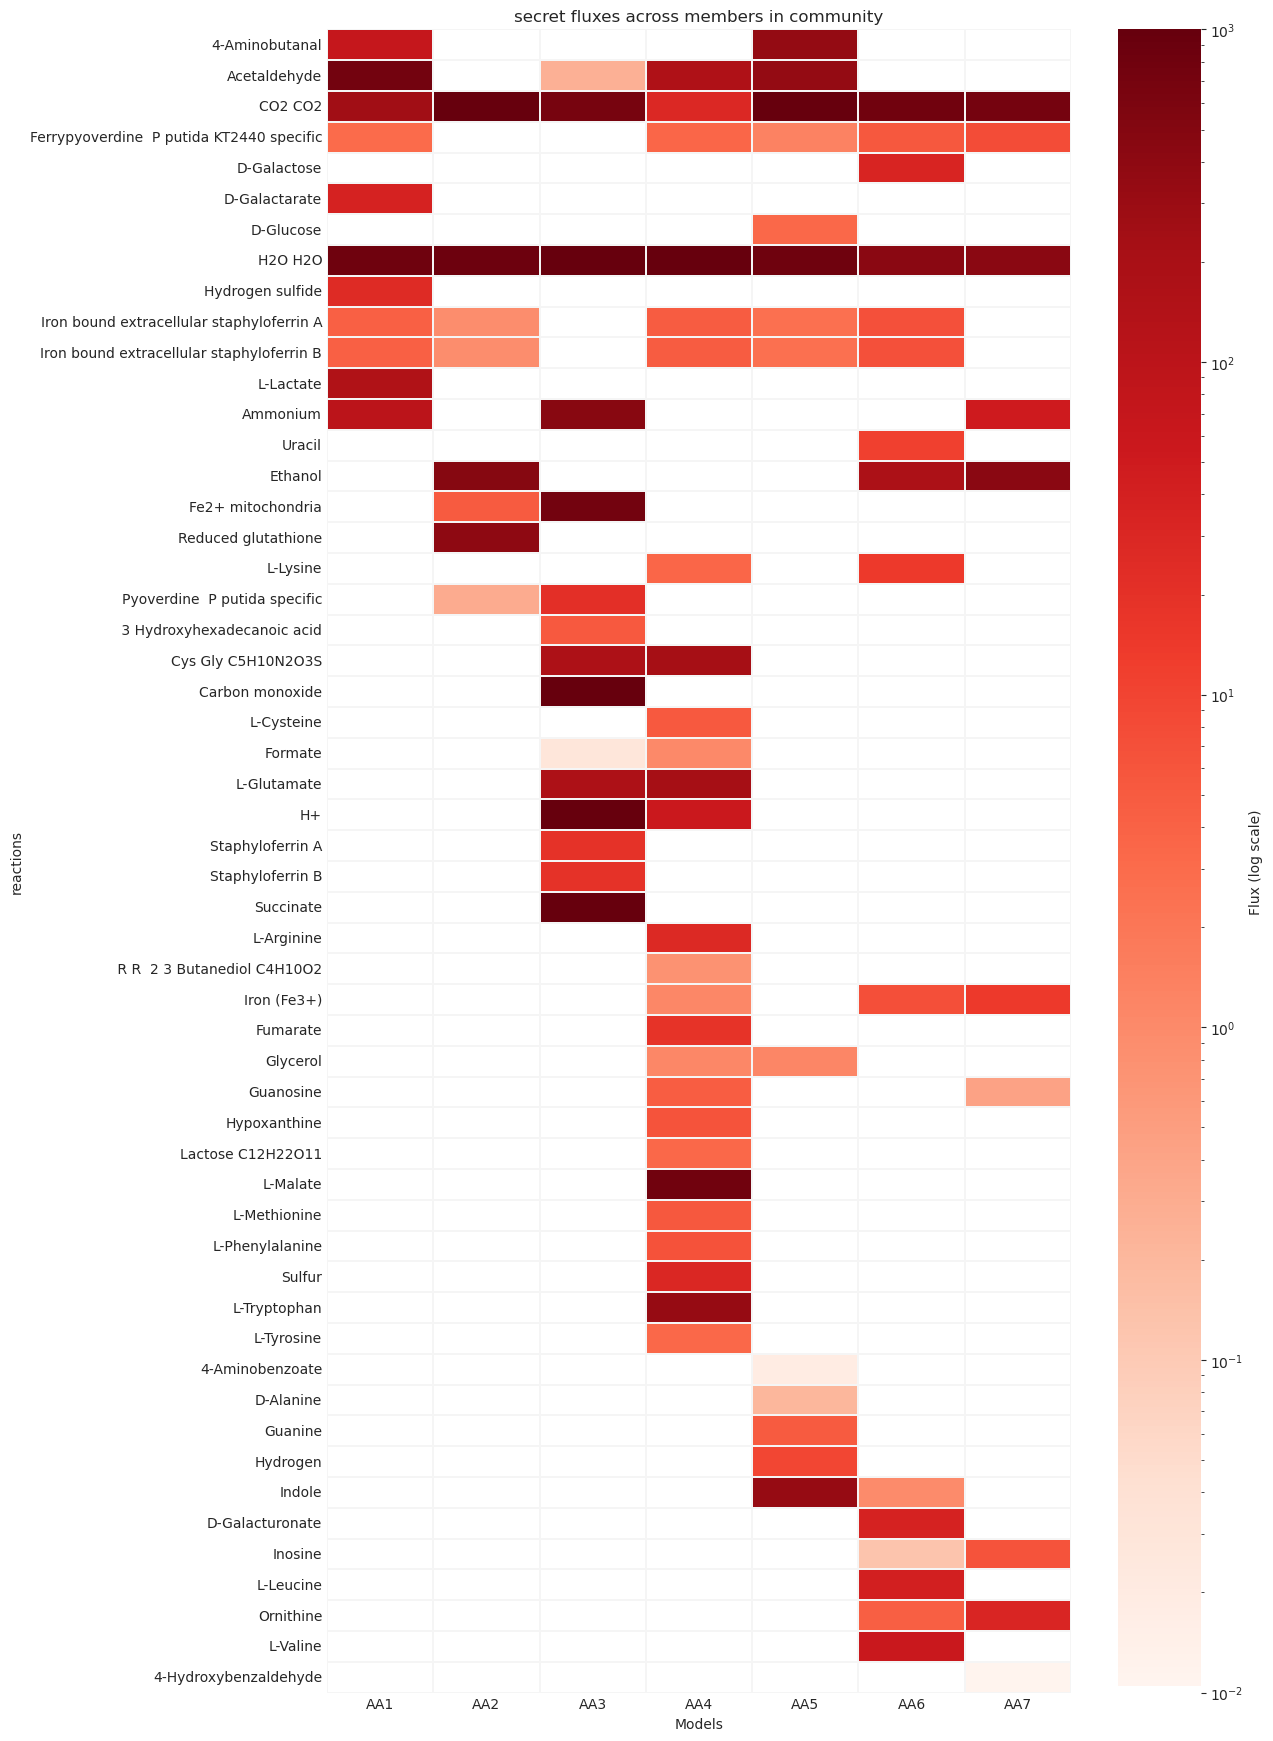

,AA1,AA2,AA3,AA4,AA5,AA6,AA7
4-Aminobutanal,69.355605,NaN,NaN,NaN,344.743028,NaN,NaN
Acetaldehyde,759.303752,NaN,0.266436,163.147368,346.767083,NaN,NaN
CO2 CO2,253.845650,999.992822,683.436056,29.753071,979.841556,796.940168,719.919915
Ferrypyoverdine P putida KT2440 specific,3.038351,NaN,NaN,3.530511,1.305306,5.578477,7.868971
D-Galactose,0.000241,NaN,NaN,NaN,NaN,33.821253,NaN
D-Galactarate,36.532446,NaN,0.000913,NaN,NaN,NaN,NaN
D-Glucose,0.000511,NaN,0.000168,NaN,3.421851,NaN,NaN
H2O H2O,830.442136,861.627771,992.100081,964.096408,817.034594,435.959625,428.726354
Hydrogen sulfide,25.230321,NaN,NaN,NaN,NaN,NaN,NaN
Iron bound extracellular staphyloferrin A,4.298063,0.935846,NaN,4.800350,2.557275,6.857317,NaN


In [78]:
heatmap_fluxes_withinCommunity(syncom_filled, models_filled, medium_combined_krumbach, "secret", vmin=0.01)

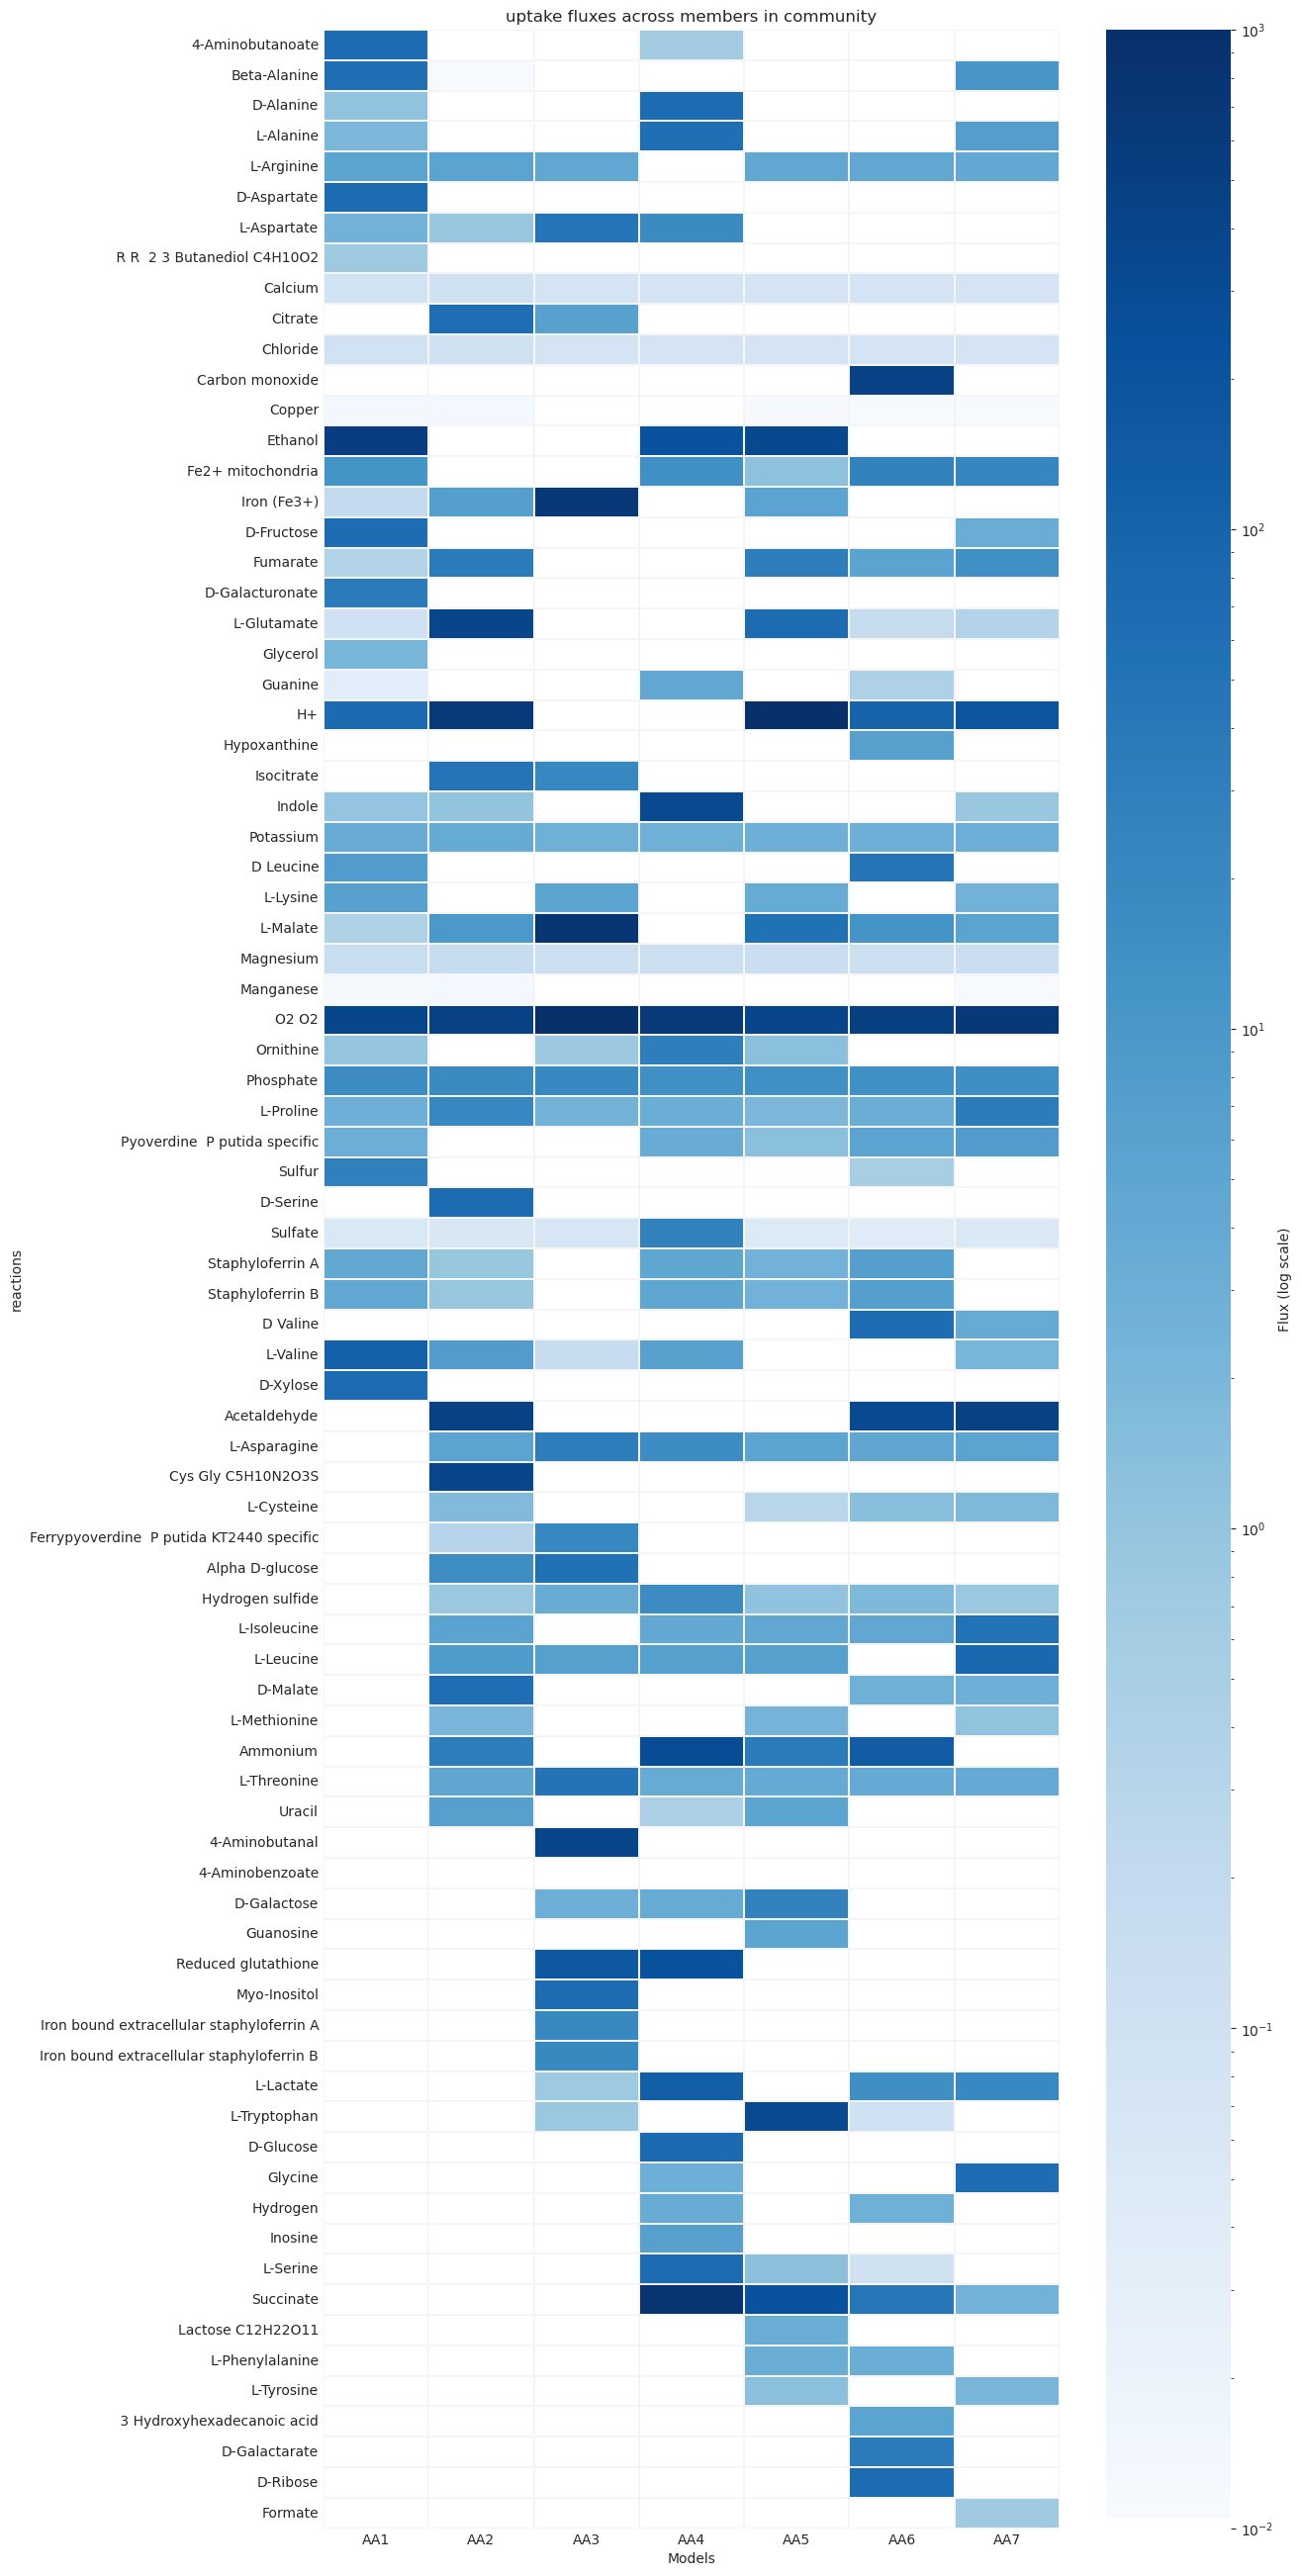

In [79]:
df_uptakes = heatmap_fluxes_withinCommunity(syncom_filled, models_filled, medium_combined_krumbach, "uptake", vmin=0.01)

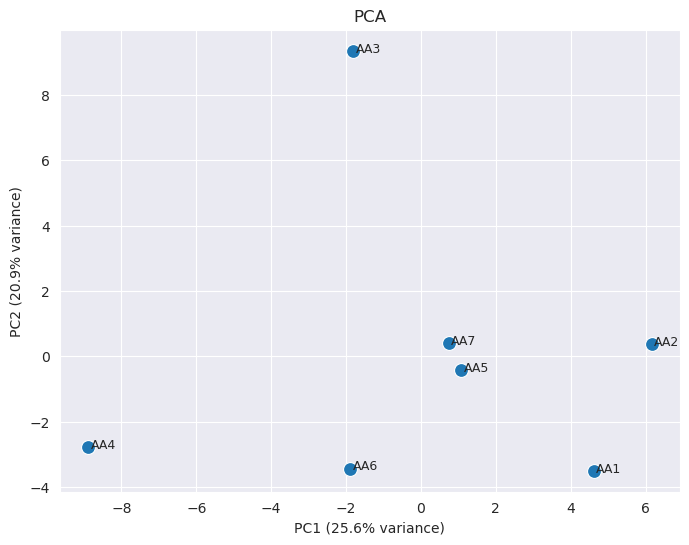

In [80]:
pca(df_uptakes.T)

## Cooperative Tradeoff - Fraction

Naveed

In [ ]:
test_fractions_community(syncom_filled, medium_combined_naveed, medium_name="Naveed")

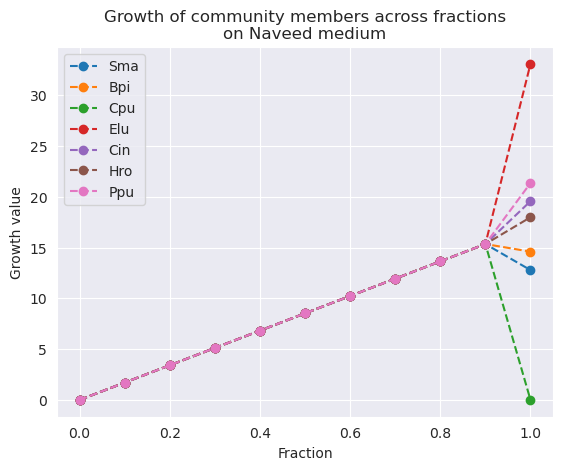

In [107]:
fractions = np.arange(0, 1.1, 0.1)
strain_codes = ["Sma", "Bpi", "Cpu", "Elu", "Cin", "Hro", "Ppu"]

n_members = len(strain_codes)
growth_vals_per_member = [[] for _ in range(n_members)]

for frac in fractions:
    _, growth_vals = community_pfba(syncom_filled, medium_combined_naveed, frac)
    for i in range(n_members):
        growth_vals_per_member[i].append(growth_vals[i])

# Plot dots & dashed lines for each strain
for i, code in enumerate(strain_codes):
    plt.plot(fractions, growth_vals_per_member[i],
             marker='o', linestyle='--', label=code)

plt.xlabel("Fraction")
plt.ylabel("Growth value")
plt.title("Growth of community members across fractions\non Naveed medium")
plt.legend()
plt.grid(True)
plt.show()


Krumbach

In [ ]:
# test_fractions_community(syncom_filled, medium_combined_krumbach, medium_name="Krumbach")
# the code below is now in this function and can be found in functions.py

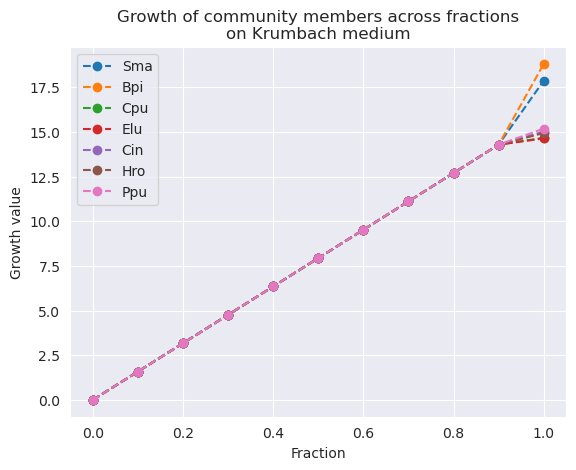

In [108]:
fractions = np.arange(0, 1.1, 0.1)
strain_codes = ["Sma", "Bpi", "Cpu", "Elu", "Cin", "Hro", "Ppu"]

n_members = len(strain_codes)
growth_vals_per_member = [[] for _ in range(n_members)]

for frac in fractions:
    _, growth_vals = community_pfba(syncom_filled, medium_combined_krumbach, frac)
    for i in range(n_members):
        growth_vals_per_member[i].append(growth_vals[i])
# Plot dots & dashed lines for each strain
for i, code in enumerate(strain_codes):
    plt.plot(fractions, growth_vals_per_member[i],
             marker='o', linestyle='--', label=code)

plt.xlabel("Fraction")
plt.ylabel("Growth value")
plt.title("Growth of community members across fractions\non Krumbach medium")
plt.legend()
plt.grid(True)
plt.show()

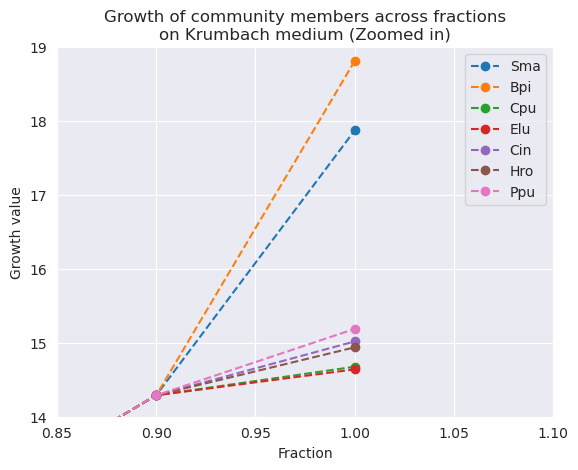

In [103]:
# Zoomed in version of 0.9 & 1 as frac
for i, code in enumerate(strain_codes):
    plt.plot(fractions, growth_vals_per_member[i],
             marker='o', linestyle='--', label=code)

plt.xlabel("Fraction")
plt.ylabel("Growth value")
plt.xlim(0.85, 1.1)
plt.ylim(14, 19)
plt.title("Growth of community members across fractions\non Krumbach medium (Zoomed in)")
plt.legend()
plt.grid(True)
plt.show()

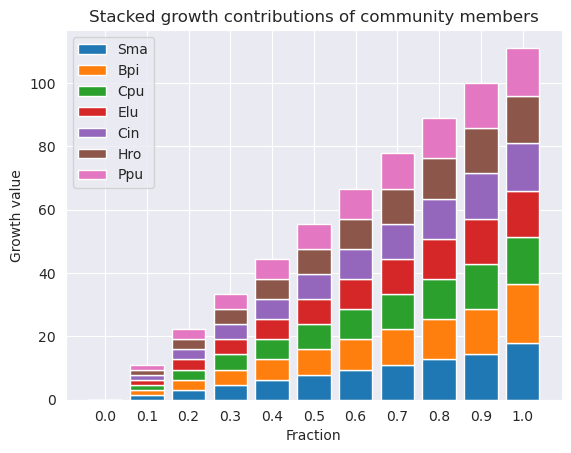

In [97]:
growth_vals_per_member = np.array(growth_vals_per_member)

# Use integer positions for bars
x = np.arange(len(fractions))

bottom = np.zeros(len(fractions))
for i, code in enumerate(strain_codes):
    plt.bar(x, growth_vals_per_member[i], bottom=bottom, label=code)
    bottom += growth_vals_per_member[i]

plt.xticks(x, [f"{f:.1f}" for f in fractions])  # show fractions as labels
plt.xlabel("Fraction")
plt.ylabel("Growth value")
plt.title("Stacked growth contributions of community members")
plt.legend()
plt.show()

In [104]:
# Zoomed in version of 0.9 & 1 as frac and more intermediate steps
fractions_small = np.arange(0.9, 1.02, 0.02)
strain_codes = ["Sma", "Bpi", "Cpu", "Elu", "Cin", "Hro", "Ppu"]

n_members = len(strain_codes)
growth_vals_per_member_small = [[] for _ in range(n_members)]

for frac in fractions_small:
    _, growth_vals = community_pfba(syncom_filled, medium_combined_krumbach, frac)
    for i in range(n_members):
        growth_vals_per_member_small[i].append(growth_vals[i])

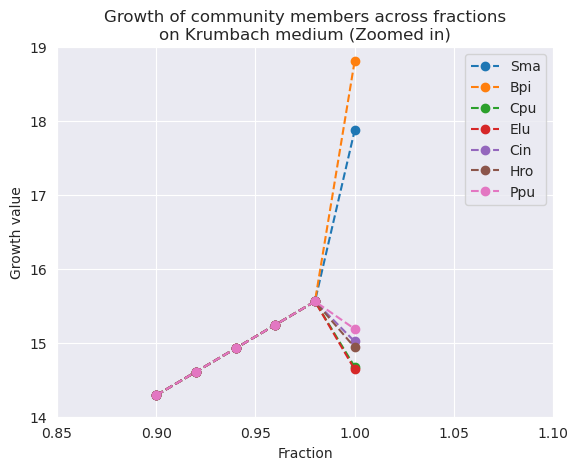

In [105]:
for i, code in enumerate(strain_codes):
    plt.plot(fractions_small, growth_vals_per_member_small[i],
             marker='o', linestyle='--', label=code)

plt.xlabel("Fraction")
plt.ylabel("Growth value")
plt.xlim(0.85, 1.1)
plt.ylim(14, 19)
plt.title("Growth of community members across fractions\non Krumbach medium (Zoomed in)")
plt.legend()
plt.grid(True)
plt.show()

# Simulations II - Cross Feeding
for Elu, Hro and Ppu (and in my case also try Cin) get all metabolites that they secret when they are grown on M9 + Glucose/Malate/Alanine (one of the three). The exudate is the medium for all the 7 strains.

QUESTION: do we take the secretion flux as the uptake bound or do we provide everything with like normal 10/1000 bounds

I am currently also adding the whole M9 medium again to grow recipients

In [ ]:
# glu = ["EX_glc__D_e"] # in all models
# malL = ["EX_mal__L_e"] # in all models
# malD = ["EX_mal__D_e"] # not in 3 & 5
# alaL = ["EX_ala__L_e"] # in all models
# alaD = ["EX_ala__D_e"] # not in 2, 6 & 7
# alaB = ["EX_ala_B_e"] # not 3, 5 & 6

In [243]:
def secreted_mets_for_crossfeed(model, m9_df, carbon_list, fva = False):
    # check carbon sources first
    if not all(carbon.startswith("EX") for carbon in carbon_list):
        raise ValueError("Please give the Exchange reaction for all carbon sources, e.g. 'EX_sucr_e'")

    # create medium with M9 and carbon source (this should only be one but it is already written so it could take multiple carbon sources)
    carbon_df = pd.DataFrame({
    "reaction": carbon_list,
    "bound": [10] * len(carbon_list)  # repeat 10 for each entry
    })

    # Concatenate to get new medium
    medium = pd.concat([m9_df, carbon_df], ignore_index=True)

    # doing pFBA or FVA
    min_val = 1e-6 # fluxes have to be above certain threshold to be considered secretion
    if not fva:
        fluxes = get_pfba_fluxes(model, medium)
        secreted = fluxes[(fluxes > min_val) & (fluxes.index.str.startswith("EX_"))]
        secreted_dict = secreted.to_dict()
    else:
        change_medium(model, medium)
        fluxies = flux_variability_analysis(model, fraction_of_optimum=0.98, pfba_factor=1.05)
        secreted = fluxies[fluxies.index.str.startswith("EX_") & (fluxies["minimum"] >= 0) & (fluxies["maximum"] > 1e-6)]
        #secreted_dict = secreted[['maximum', 'minimum']].mean(axis=1).to_dict()
        secreted_dict = secreted[['maximum', 'minimum']].mean(axis=1).clip(upper=10).to_dict() # this makes average but if it is above 10 then set it to 10

    return secreted_dict

In [224]:
def cross_feed(model, m9_df, supernatant, fixed_bound = None):
    # supernatant is the return of secreted_mets_for_crossfeed

    # turn secreted dict into df
    supernatant = pd.DataFrame(list(supernatant.items()), columns=["reaction", "bound"])

    if fixed_bound is not None: # have the option to set uptake bound yourself
        supernatant["bound"] = fixed_bound

    # combine with m9
    whole_medium = pd.concat([m9_df, supernatant], ignore_index=True)

    growth_val = test_medium(model, whole_medium)

    return growth_val

In [225]:
def met_name(models, rxn_id):
    for model in models.values():
        if rxn_id in model.reactions:
            met = list(model.reactions.get_by_id(rxn_id).metabolites.keys())[0].name
            return met
    return "Not in models"

In [230]:
def whole_cross_feeding(models, donors, possible_carbons, m9_df, fixed_bound = None, fva=False):
    # Collect results (growth) in a dict of dicts
    results = {}

    for carbon in possible_carbons:
        carbon_name = met_name(models, carbon[0])
        for donor in donors:
            row_name = f"{carbon_name} & {donor}"
            results[row_name] = {}

            # simulate secretion
            if donor != "Fresh":
                secretion = secreted_mets_for_crossfeed(models[donor], m9, carbon, fva)

            # test each recipient
            for recip in models.values():
                if donor != "Fresh":
                    print(donor, carbon, secretion)
                    growth = cross_feed(recip, m9_df, secretion, fixed_bound)
                else: # Fresh aka no cross-feeding yet
                    carbon_dict = {key: 10 for key in carbon}
                    growth = cross_feed(recip, m9_df, carbon_dict, fixed_bound)

                results[row_name][recip.id] = growth

    # Convert to dataframe
    df_results = pd.DataFrame(results).T  # rows=conditions, cols=models

    ######### Plot #########
    plt.figure(figsize=(10, 8))
    ax = sns.heatmap(
        df_results, annot=True, cmap="YlOrRd", fmt=".2f",
        cbar_kws={"label": "Growth\n[mmol/(gDW h)]", "orientation":"vertical"}
    )

    # Access and move colorbar
    cbar = ax.collections[0].colorbar
    cbar.ax.set_position([0.87, 0.1, 0.03, 0.8])  # [x, y, width, height]


    # Left y-axis labels
    left_labels = []
    for c in possible_carbons:
        met = met_name(models, c[0])   # translate reaction ID -> metabolite name
        left_labels.extend([met] * len(donors))
    ax.set_yticks(np.arange(len(left_labels)) + 0.5)
    ax.set_yticklabels(left_labels, rotation=0)
    ax.set_ylabel("Carbon Source for Donor Strain Growth")

    # Right y-axis labels
    right_labels = [d if d == "Fresh" else models[d].id for d in donors] * len(possible_carbons)
    ax_right = ax.twinx()
    ax_right.set_ylim(ax.get_ylim())
    ax_right.set_ylabel("Medium for Recipient")

    # Remove automatic ticks/grid
    ax_right.yaxis.set_ticks([])
    ax_right.grid(False)

    ax_right.set_yticks(np.arange(len(right_labels)) + 0.5)
    ax_right.set_yticklabels(right_labels, rotation=0)


    for i in range(len(donors), len(donors)*len(possible_carbons)+1, len(donors)):  # add horizontal lines
        plt.hlines(i, *plt.xlim(), color='black', linewidth=1)
    ax.set_xlabel("Recipient Strain")
    plt.title("Cross-feeding")
    plt.show()

In [176]:
donors = ["Fresh", "AA4f", "AA5f", "AA6f", "AA7f"]
#donors = ["Fresh", "AA4f", "AA6f", "AA7f"]
possible_carbons = [["EX_glc__D_e"], ["EX_mal__L_e"], ["EX_ala__L_e"]]

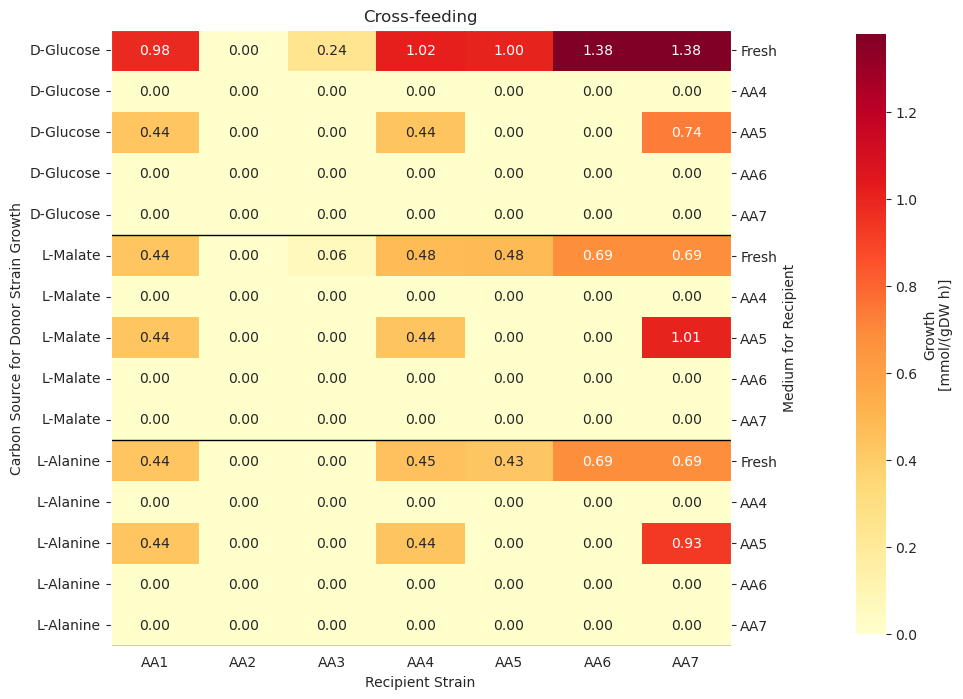

In [192]:
whole_cross_feeding(models_filled, donors, possible_carbons, m9, 10)

AA4f ['EX_glc__D_e'] {'EX_12ppd__R_e': 0.1492307692308117, 'EX_4abut_e': 0.10777777777781625, 'EX_4hba_e': 0.00022464152177799788, 'EX_4hbz_e': 0.07843665768196101, 'EX_5drib_e': 0.04038429303295543, 'EX_LalaDgluMdapDala_e': 0.029663608562693688, 'EX_LalaDgluMdap_e': 0.03439716312056933, 'EX_acald_e': 0.269444444444483, 'EX_acglu_e': 0.0960396039604019, 'EX_acser_e': 0.13857142857144922, 'EX_agm_e': 0.0950980392157175, 'EX_ala__D_e': 0.148312707610233, 'EX_ala__L_e': 0.220454545454574, 'EX_alaala_e': 0.07293233082709032, 'EX_anhgm_e': 0.02852941176470625, 'EX_arab__D_e': 0.11640000000004802, 'EX_arg__L_e': 0.09417475728155508, 'EX_asp__L_e': 0.19795918367353077, 'EX_btd_RR_e': 0.12278481012661879, 'EX_cellb_e': 0.04754901960784841, 'EX_cgly_e': 0.09276541759847395, 'EX_co2_e': 10.0, 'EX_cys__L_e': 0.14477611940302865, 'EX_enter_e': 0.0187620889748564, 'EX_etha_e': 0.1473274328804852, 'EX_etoh_e': 0.22558139534886146, 'EX_fad_e': 0.019543317662862488, 'EX_fmn_e': 0.029892141756551, 'EX_

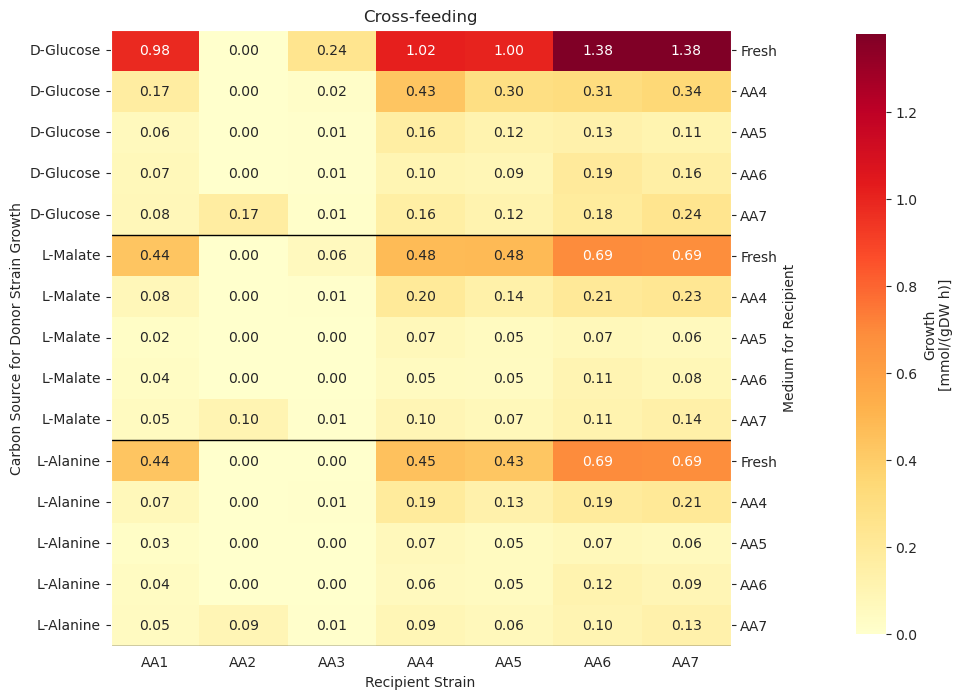

In [244]:
whole_cross_feeding(models_filled, donors, possible_carbons, m9, fva=True)

# Visualisations

In [ ]:
from pyvis.network import Network

def visualise_network(model, medium, rxn_list, file_name):
    with model:
        change_medium(model, medium)
        com_fluxes = pfba(model).fluxes
    com_fluxes = com_fluxes.rename("flux").reset_index().rename(columns={"index": "reaction"})
    rxns = set(rxn_list)  # specify list of reactions that you want to visualise, e.g. ["rxn1", "rxn2", ...]
    net = Network(height="700px", width="100%", notebook=True, directed=True)

    for rxn in model.reactions:
        if rxn.id in rxns:

            flux = com_fluxes.loc[com_fluxes["reaction"] == rxn.id, "flux"].values[0]

            # Logarithmic scaling for edge width
            scaling_factor = 5
            if abs(flux) > 1e-6:
                width = min(max(np.log10(abs(flux) + 1) * scaling_factor, 1.5), 15.0)
            else:
                width = 1.0
            print(rxn.id, width)

            # Add reactants → reaction node
            for met in rxn.reactants:
                #net.add_node(met.id, label=met.id, color="lightblue", shape="ellipse")
                net.add_node(rxn.id, label=rxn.id, color="red", shape="box")
                #net.add_edge(met.id, rxn.id, color='black')  # reactant edges
            # Add reaction node → products
            for met in rxn.products:
                net.add_node(met.id, label=met.id, color="lightblue", shape="ellipse")
                net.add_edge(met.id, rxn.id, color='black', width=width)  # product edges

    # this file is exported and then can be opened and examined your browser)
    net.show(file_name)
    print(f"File saved.")


### Phylo visualisation

In [ ]:
from Bio import Phylo
import matplotlib.pyplot as plt

tree = Phylo.read("../phyliptree.phy", "newick")

fig = plt.figure(figsize=(12, 8))  # bigger figure helps
ax = fig.add_subplot(1, 1, 1)

Phylo.draw(tree, do_show=False, axes=ax)

plt.tight_layout()  # tries to optimize spacing
plt.show()


In [ ]:
from Bio import Phylo
import matplotlib.pyplot as plt

# Read your tree (make sure it's in a supported format)
tree = Phylo.read("../phyliptree.phy", "newick")

# Plot the tree
Phylo.draw(tree)
plt.show()


In [ ]:
from ete3 import Tree

# Load the tree from your .phy file
t = Tree("../phyliptree.phy", format=1)

# Show interactive tree viewer
t.show()


## Poster visualisations
Plots that were designed specifically for my poster for the MPA conference in Vienna; because they have to fit the poster maybe not all the infotmation is displayed that I normally would do or that I have done with my plots earlier in this notebook.

In [27]:
def filter_dataframe(df, threshold):
    # set values below the threshold to NaN
    filtered = df.where(df >= threshold)
    # drop rows where **all** values are NaN (i.e., all were below threshold)
    filtered = filtered.dropna(how='all')
    return filtered

In [28]:
threshold = 0.1

In [35]:
# get uptake fluxes only for our 7 models withput community
data = {}

for model_name, model_obj in models.items():
    medium = minimal_medium(model_obj, 2)
    medium = medium.rename("bound").reset_index().rename(columns={"index": "reaction"})
    flux_dict = get_fluxes_for_heatmap(model_obj, medium, type="uptake", c7_all_ex="yes", dict_with_rxn="yes")


    flux_dict_sorted = {}
    # this is mostly if we would use community to change reaction names that community has the same as the individuals
    # attention (if relevant in the future): this overwrites flux values because EX_met1_e_AA1 is the same aus EX_met1_e_AA2
    for rxn_id, flux in flux_dict.items():
        # Rule 1: Remove '__AA[1-7]' suffix if present
        if re.search(r'__(AA[1-7])$', rxn_id):
            clean_id = re.sub(r'__(AA[1-7])$', '', rxn_id)
        # Rule 2: If ends with '_m', replace it with '_e'
        elif rxn_id.endswith('_m'):
            clean_id = rxn_id[:-2] + '_e'
        else:
            clean_id = rxn_id

        flux_dict_sorted[clean_id] = flux

    data[model_name] = flux_dict_sorted

df = pd.DataFrame(data).fillna(0)
df = df.abs()
df = df.replace(0, np.nan)

df_uptakes_poster = filter_dataframe(df, threshold=threshold)

In [36]:
data = {}

for model_name, model_obj in models.items():
    medium = minimal_medium(model_obj, 2)
    medium = medium.rename("bound").reset_index().rename(columns={"index": "reaction"})
    flux_dict = get_fluxes_for_heatmap(model_obj, medium, type="secret", c7_all_ex="yes", dict_with_rxn="yes")

    flux_dict_sorted = {}
    for rxn_id, flux in flux_dict.items():
        flux_dict_sorted[rxn_id] = flux

    data[model_name] = flux_dict_sorted

df = pd.DataFrame(data).fillna(0)
df = df.abs()
df = df.replace(0, np.nan)

df_secrets_poster = filter_dataframe(df, threshold=threshold)

<Axes: >

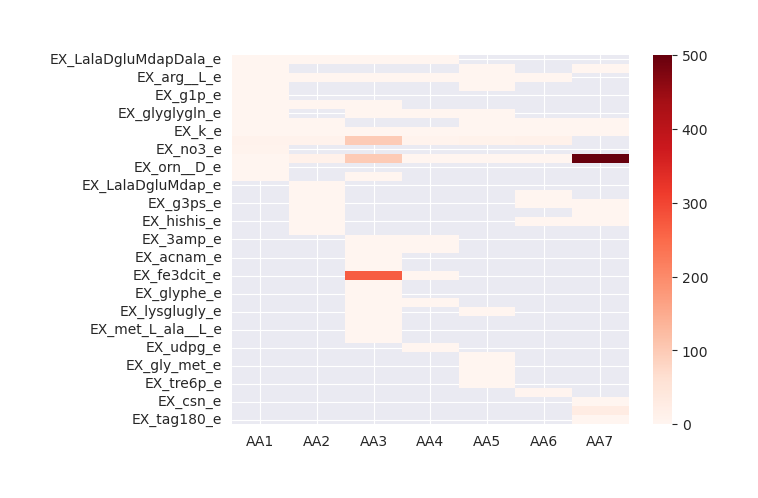

In [170]:
sns.heatmap(df_uptakes_poster, cmap="Reds")

### Upset Plot

In [26]:
# rename cols so they show up as the labels
name_changes = {"AA1": "Sma",
                   "AA2": "Bpi",
                   "AA3": "Cpu",
                   "AA4": "Elu",
                   "AA5": "Cin",
                   "AA6": "Hro",
                   "AA7": "Ppu"}

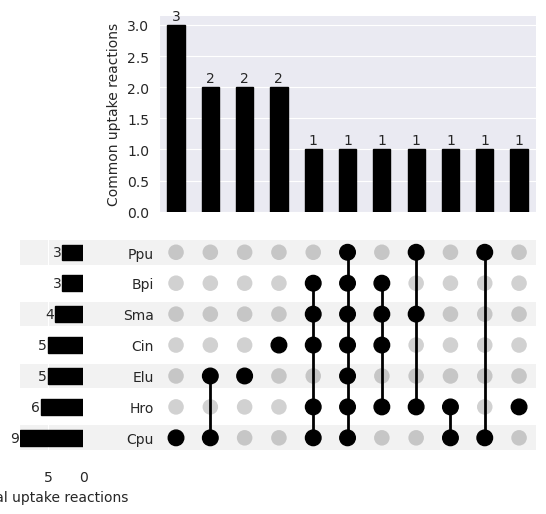

In [37]:
# Make boolean matrix: True = uptake present
bool_df = df_secrets_poster.notna()
bool_df = bool_df.rename(columns=name_changes)

# Convert to UpSet input format (multi-index of species presence)
upset_data = from_indicators(bool_df)

# Plot
upset = UpSet(
    upset_data,
    subset_size='count',
    show_counts=True,
    sort_by='cardinality'  # Sort by size of overlap (descending)
).plot()

plt.gca().set_ylabel("Common uptake reactions")
upset["totals"].set_xlabel("Total uptake reactions")

#plt.savefig("../Figures/upset_niches.svg", format="svg", bbox_inches="tight")
plt.show()


In [293]:
from matplotlib.patches import Patch

def plot_fluxes(df_uptake, df_secretion, model_name, threshold=threshold):
    # Rename model_name for display
    display_name = name_changes.get(model_name, model_name)

    # Get the model object (e.g. AA1) to extract metabolite names
    model = models[model_name]

    # Get and filter fluxes
    uptake = df_uptake[model_name].dropna()
    uptake = uptake[uptake.abs() > threshold]

    secretion = df_secretion[model_name].dropna()
    secretion = secretion[secretion.abs() > threshold]
    secretion = -abs(secretion)

    # Create a combined DataFrame with flux values and labels
    combined = pd.concat([uptake, secretion])
    flux_type = ['uptake'] * len(uptake) + ['secretion'] * len(secretion)
    combined_df = pd.DataFrame({'flux': combined, 'type': flux_type})

    # Sort by absolute flux value
    combined_df['abs_flux'] = combined_df['flux'].abs()
    combined_df = combined_df.sort_values(by='abs_flux', ascending=False)

    # Get metabolite names
    def get_met_name(rid):
        rxn = model.reactions.get_by_id(rid)
        return list(rxn.metabolites.keys())[0].name

    x_labels = [get_met_name(rid) for rid in combined_df.index]

    # Set colors
    color_map = {'uptake': 'mediumseagreen', 'secretion': 'orange'}
    bar_colors = [color_map[t] for t in combined_df['type']]

    # Plot
    plt.figure(figsize=(10,6))
    plt.bar(range(len(combined_df)), combined_df['flux'], color=bar_colors)

    plt.axhline(0, color='black', linewidth=0.8)
    plt.ylabel('log-scaled flux [mmol/(gDW h)]')
    plt.title(f'Uptake (positive) and Secretion (negative) fluxes for {display_name}')

    plt.xticks(ticks=range(len(combined_df)), labels=x_labels, rotation=45, ha='right')
    plt.yscale('symlog', linthresh=threshold)
    plt.ylim(combined_df['flux'].min() - 50, combined_df['flux'].max() + 10)

    # Add legend
    legend_elements = [
        Patch(facecolor='mediumseagreen', label='Uptake'),
        Patch(facecolor='orange', label='Secretion')
    ]
    plt.legend(handles=legend_elements, loc='upper right')

    plt.tight_layout()
    plt.savefig(f"../Figures/fluxes_{display_name}.svg", format="svg", bbox_inches="tight")
    plt.show()


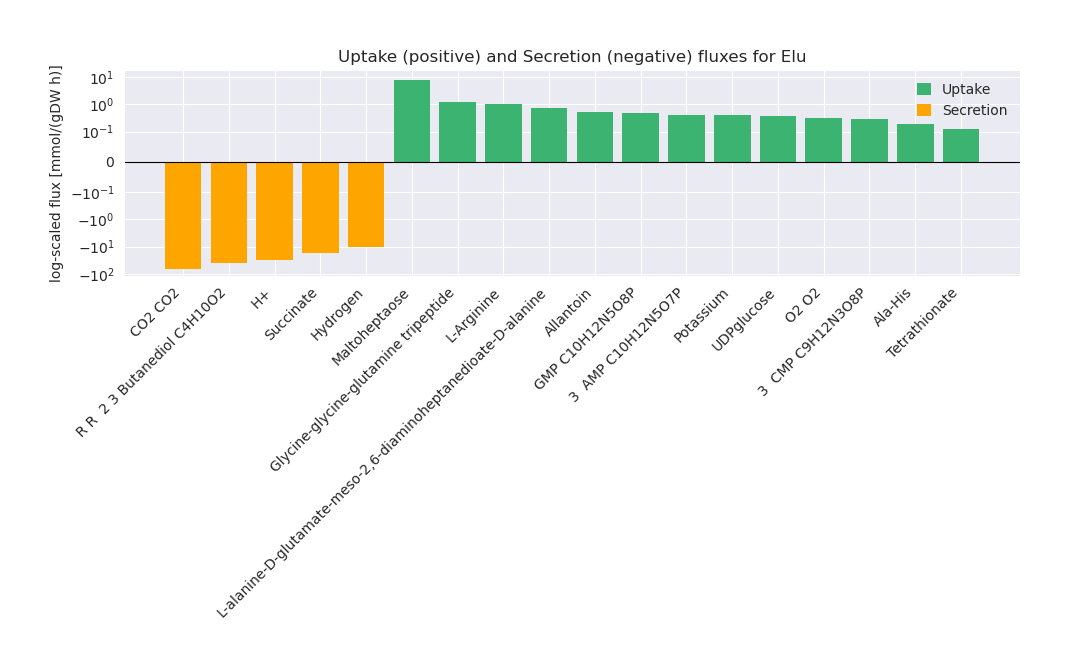

In [294]:
plot_fluxes(df_uptakes_poster, df_secrets_poster, "AA4")

# Spielplatz

Lactate Investigation

In [27]:
get_met_unknown(models_filled, "lcts_c")

lcts_c (Lactose C12H22O11 (C12H22O11, 0)) is found  models: ['AA1', 'AA2', 'AA3', 'AA4', 'AA5', 'AA6', 'AA7'] and in reactions: {'LACZ', 'LCTStpp', 'LCTSt3ipp', 'LCTSabc', 'LCTSt'}


In [28]:
get_met_unknown(models_filled, "lcts_e")

lcts_e (Lactose C12H22O11 (C12H22O11, 0)) is found  models: ['AA1', 'AA2', 'AA3', 'AA4', 'AA5', 'AA6', 'AA7'] and in reactions: {'LACpts', 'EX_lcts_e', 'LCTSabc', 'LCTSt', 'LCTStex'}


In [29]:
get_rxn_unknown(models_filled, "LACpts")

LACpts is found in: ['AA4']
LACpts: lcts_e + pep_c <=> lac6p_c + pyr_c


In [38]:
get_rxn_unknown(models_filled, "LCTSt")

LCTSt is found in: ['AA5', 'AA7']
LCTSt: h_e + lcts_e --> h_c + lcts_c


In [66]:
get_met(AA3f, "lcts_p")

Lactose C12H22O11 (C12H22O11)
{'LACZpp': 'h2o_p + lcts_p --> gal_p + glc__D_p', 'LCTSt3ipp': 'h_p + lcts_c --> h_c + lcts_p'}


In [60]:
get_met(AA5f, "lcts_p")

Lactose C12H22O11 (C12H22O11)
{'LCTSt3ipp': 'h_p + lcts_c --> h_c + lcts_p', 'LACZpp': 'h2o_p + lcts_p --> gal_p + glc__D_p'}


In [57]:
get_met(AA5f, "lcts_p")

Lactose C12H22O11 (C12H22O11)
{'LCTSt3ipp': 'h_p + lcts_c --> h_c + lcts_p', 'LACZpp': 'h2o_p + lcts_p --> gal_p + glc__D_p'}


In [44]:
get_rxn(AA7f, "LACZpp", GPR=True)

LACZpp: h2o_p + lcts_p --> gal_p + glc__D_p



In [55]:
for rxn in AA6f.reactions:
    if str("WP_079216881_1") in str(rxn.gpr):
        print(rxn.id)

LACZ


In [52]:
AA6f.reactions.LACZ.gpr

cobra.core.gene.GPR('WP_079216881_1')

In [49]:
AA6f.reactions.LACZ

Reaction identifier,LACZ
Name,B-galactosidase
Memory address,0x7d19d3104e50
Stoichiometry,h2o_c + lcts_c --> gal_c + glc__D_c H2O H2O + Lactose C12H22O11 --> D-Galactose + D-Glucose
GPR,WP_079216881_1
Lower bound,0.0
Upper bound,1000.0


In [64]:
AA1f.reactions.LACZpp

Reaction identifier,LACZpp
Name,B-galactosidase
Memory address,0x7d19d3cdeaa0
Stoichiometry,h2o_p + lcts_p --> gal_p + glc__D_p H2O H2O + Lactose C12H22O11 --> D-Galactose + D-Glucose
GPR,WP_079223808_1 or WP_079225061_1
Lower bound,0.0
Upper bound,1000.0


In [83]:
get_met_unknown(models_filled, "xyl__D_e")

xyl__D_e (D-Xylose (C5H10O5, 0)) is found  models: ['AA1', 'AA2', 'AA3', 'AA4', 'AA5', 'AA6'] and in reactions: {'XYLabc', 'EX_xyl__D_e', 'XYLtex', 'XYLt2', 'XYLt'}
